# **Assessment 2**

For our second assessment, we will be looking at sequential weather data. The data contains a number of relevant weather variables, recorded daily for a European city during a period of four decades.

However, this dataset has been corrupted, and some of the daily measurements are now missing. The goal of this assessment is to develop a neural network architecture that can recover the missing measurements!

<br>

---

<br>

The dataset has been saved as `.csv` files and has been separated into a `training_set/` folder and a `test_set.csv` file. The `training_set/` contains data for three of the four decades, separated in one individual file per decade:

- `training_set_0.csv` contains corrupted data for the first decade; `training_set_0_nogaps.csv` contains the same data before it was corrupted.
- `training_set_1.csv` contains corrupted data for the second decade; `training_set_1_nogaps.csv` contains the same data before it was corrupted.
- `training_set_2.csv` contains corrupted data for the third decade; `training_set_2_nogaps.csv` contains the same data before it was corrupted.

The `test_set.csv` file contains the remaining decade; this data is corrupted and contains gaps, but we have lost access to the data before corruption.

The architecture that you design in this assessment should use the data contained inside the `training_set` in order to recover the missing information in the data in `test_set.csv`. Note that decades `0`, `1`, and `2` are not necessarily consecutive.

Inside each of the `.csv` files, you will find the following columns:

- `date`
- `cloud_cover`
- `sunshine`
- `global_radiation`
- `max_temp`
- `mean_temp`
- `min_temp`
- `precipitation`
- `pressure`

<br>

All answers to the assessment should be contained within the structure below, but you are free to add new code and text cells as required to your answers. Read the text for each question and follow the instructions carefully. Answers that do not follow this structure will not be marked. **Do NOT change the name of this file.**

Please, **make sure to execute all your cells and save the result of the execution**. We will only mark cells that have been executed and will not execute any cells ourselves.

<br>

---

<br>

<br><br>

## **Question 1**  (25%)

Load the training and test datasets. Then, use the space below to present the following set of figures:

1. Using line plots, show the different variables in each dataset, both before and after corruption. Choose a single decade to plot, and plot the first 365 days of data. Plot the time series for each variable in an independent axis window. Make sure the axis windows are sized appropriately so that trends and corruption in the variables can be easily observed.
2. Plot a histogram for each variable in each dataset, across all decades, both before and after corruption.

<br>

In [5]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler



In [7]:
#run on GPU
device = torch.device( "cpu")

In [8]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Navigate to a specific folder in your Drive
file_path = '/content/drive/My Drive/Data/training_set/'


corrupted_file0 = os.path.join(file_path, "training_set_0.csv")
non_corrupted_file0 = os.path.join(file_path, "training_set_0_nogaps.csv")

corrupted_file1 = os.path.join(file_path, "training_set_1.csv")
non_corrupted_file1 = os.path.join(file_path, "training_set_1_nogaps.csv")

corrupted_file2 = os.path.join(file_path, "training_set_2.csv")
non_corrupted_file2 = os.path.join(file_path, "training_set_2_nogaps.csv")


corrupted_data0 = pd.read_csv(corrupted_file0)
non_corrupted_data0 = pd.read_csv(non_corrupted_file0)

corrupted_data1 = pd.read_csv(corrupted_file1)
non_corrupted_data1 = pd.read_csv(non_corrupted_file1)

corrupted_data2 = pd.read_csv(corrupted_file2)
non_corrupted_data2 = pd.read_csv(non_corrupted_file2)



all_corr_data = pd.concat([corrupted_data0, corrupted_data1, corrupted_data2])
all_non_corr_data = pd.concat([non_corrupted_data0, non_corrupted_data1, non_corrupted_data2])


test_set = pd.read_csv(os.path.join('/content/drive/My Drive/Data/', "test_set.csv"))


Mounted at /content/drive


In [9]:
non_corrupted_data0.head()

date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
0     0          4.0       0.2              10.6       2.1       -1.3   
1     1          2.0       6.7              58.8      11.4       -2.1   
2     2          7.9      -0.0               5.7       9.6        3.0   
3     3          4.9       4.1              41.1       8.0        4.7   
4     4          3.9       1.3              19.5       8.4        4.8   

   min_temp  precipitation  pressure  
0      -4.2            0.0  101282.7  
1      -6.0            0.2  102455.7  
2      -5.8            9.9  101920.4  
3       0.8            0.0  100441.5  
4       1.7            0.0  100625.2

In [10]:
corrupted_data0.head()

date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
0     0          4.0       0.2              10.6       2.1       -1.3   
1     1          2.0       6.7              58.8      11.4       -2.1   
2     2          7.9      -0.0               5.7       9.6        NaN   
3     3          4.9       4.1              41.1       8.0        NaN   
4     4          3.9       1.3              19.5       8.4        NaN   

   min_temp  precipitation  pressure  
0      -4.2            0.0  101282.7  
1      -6.0            0.2  102455.7  
2      -5.8            9.9  101920.4  
3       0.8            0.0  100441.5  
4       1.7            0.0  100625.2

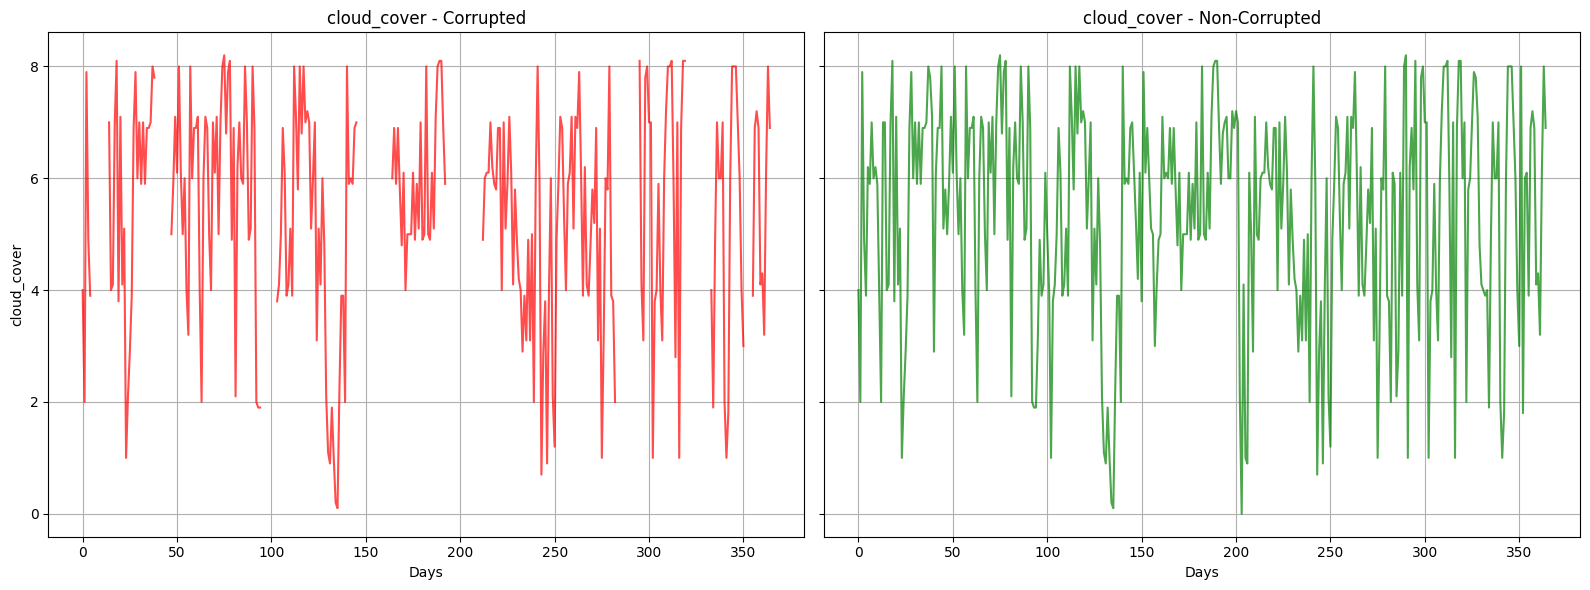

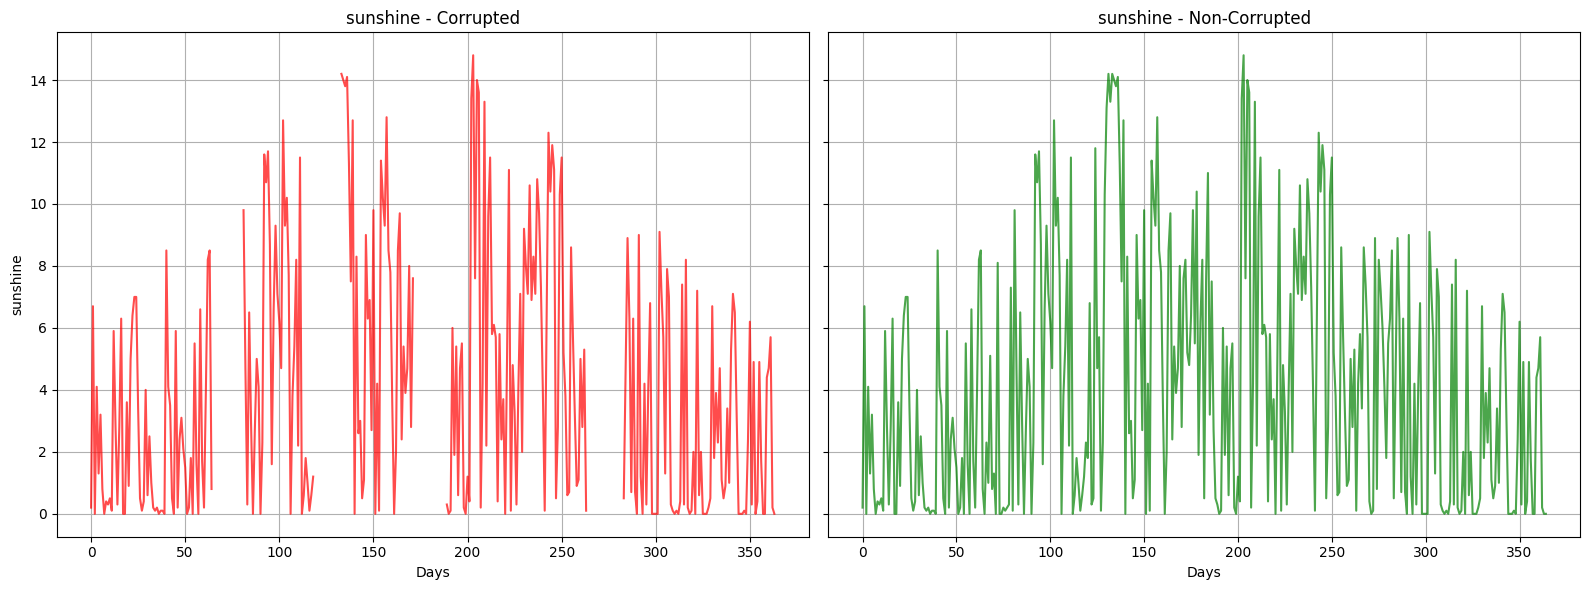

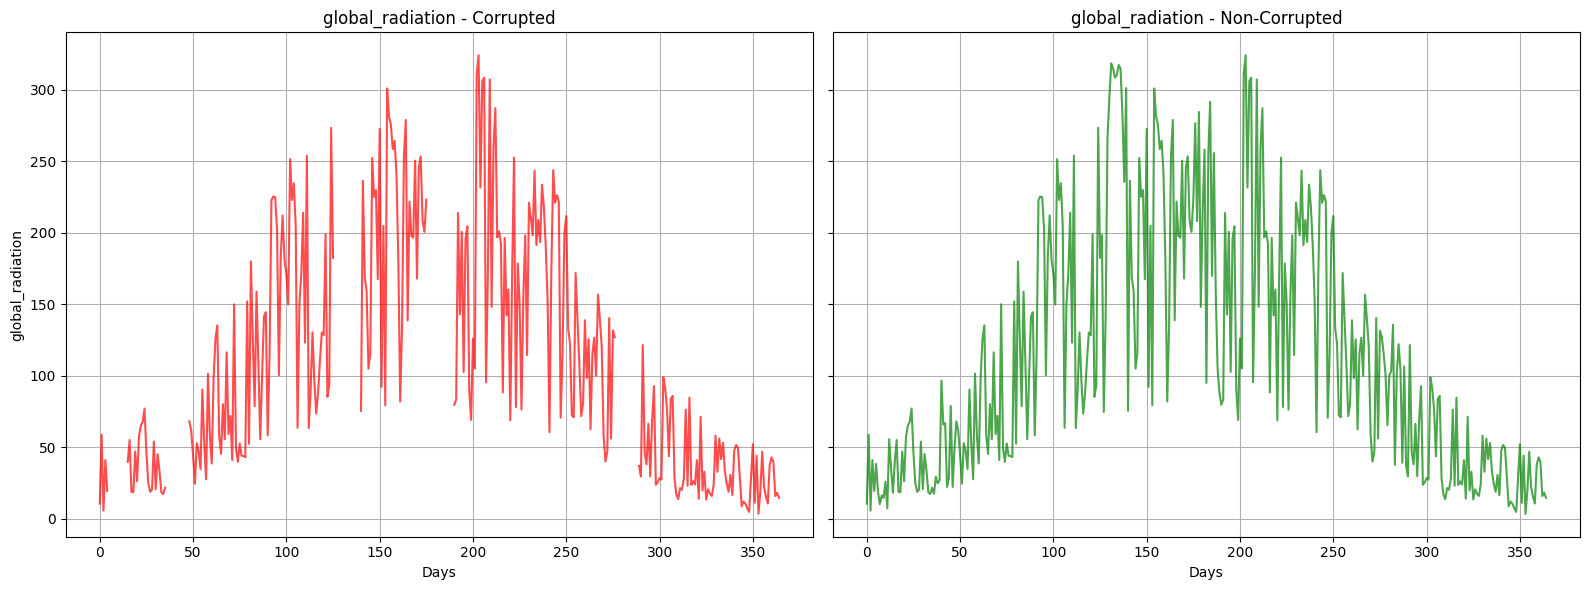

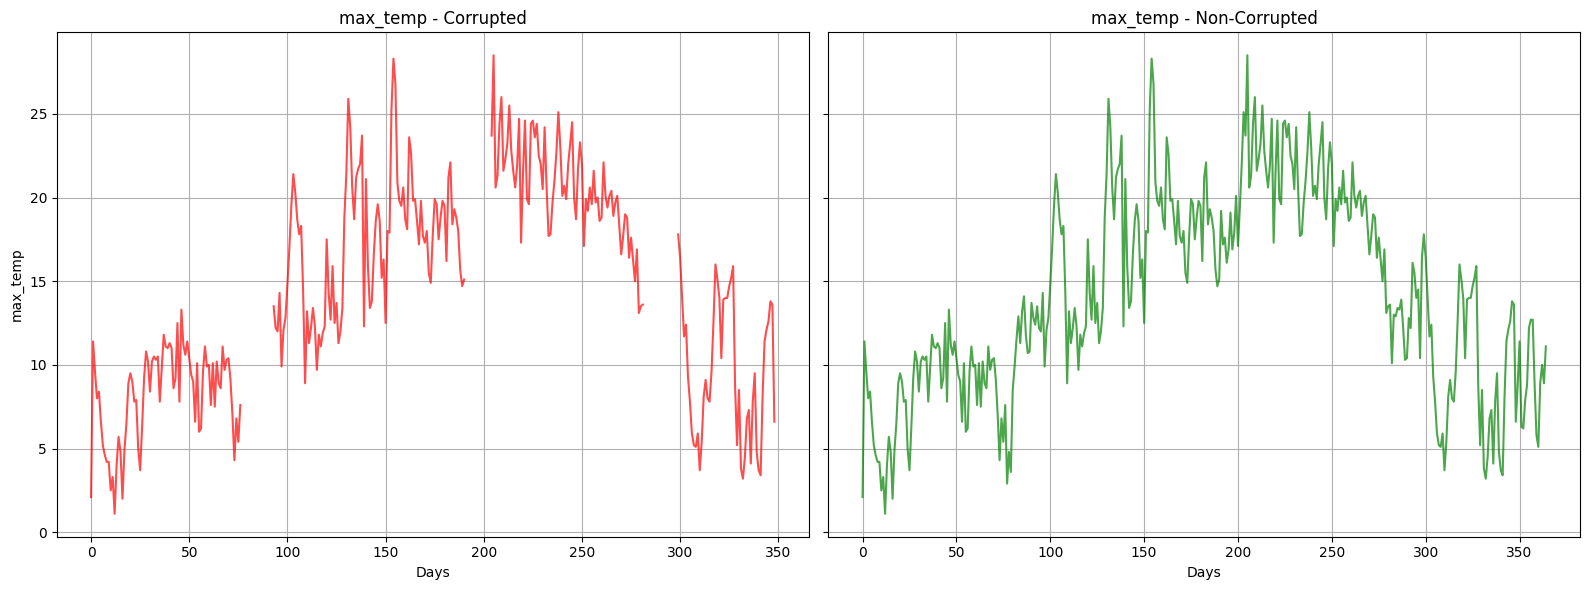

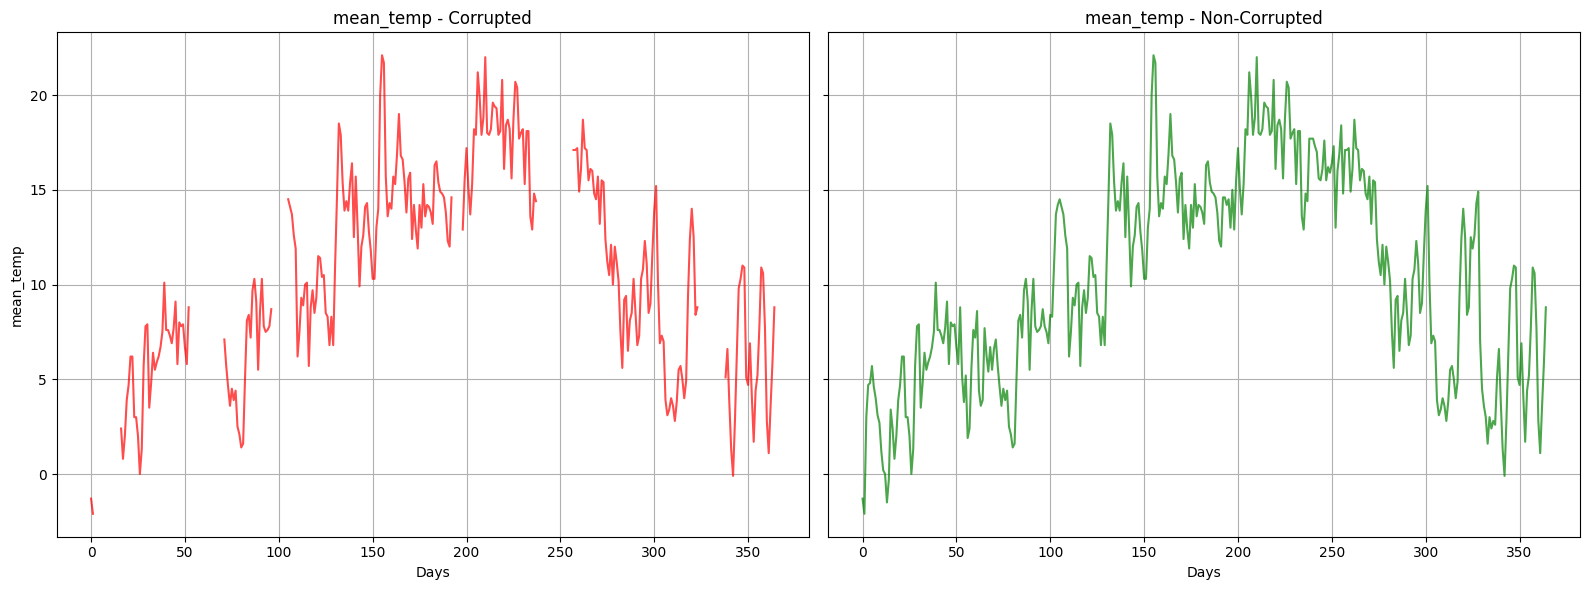

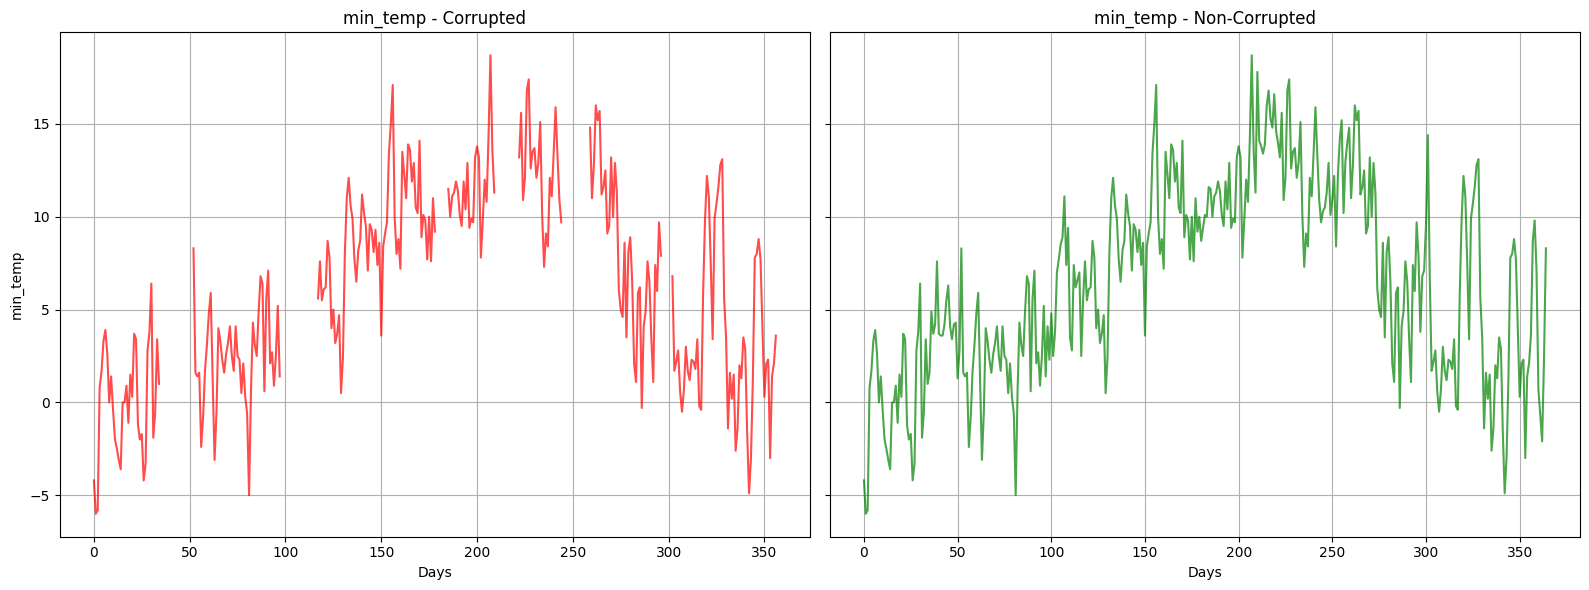

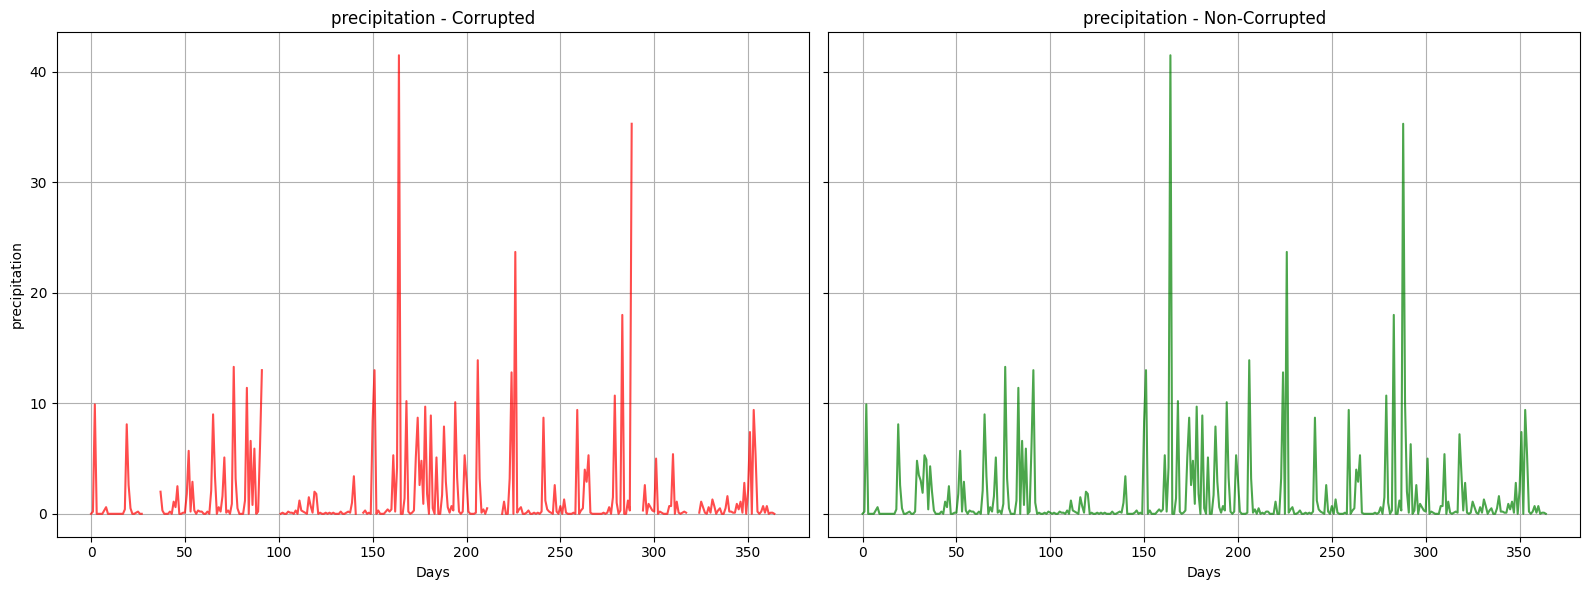

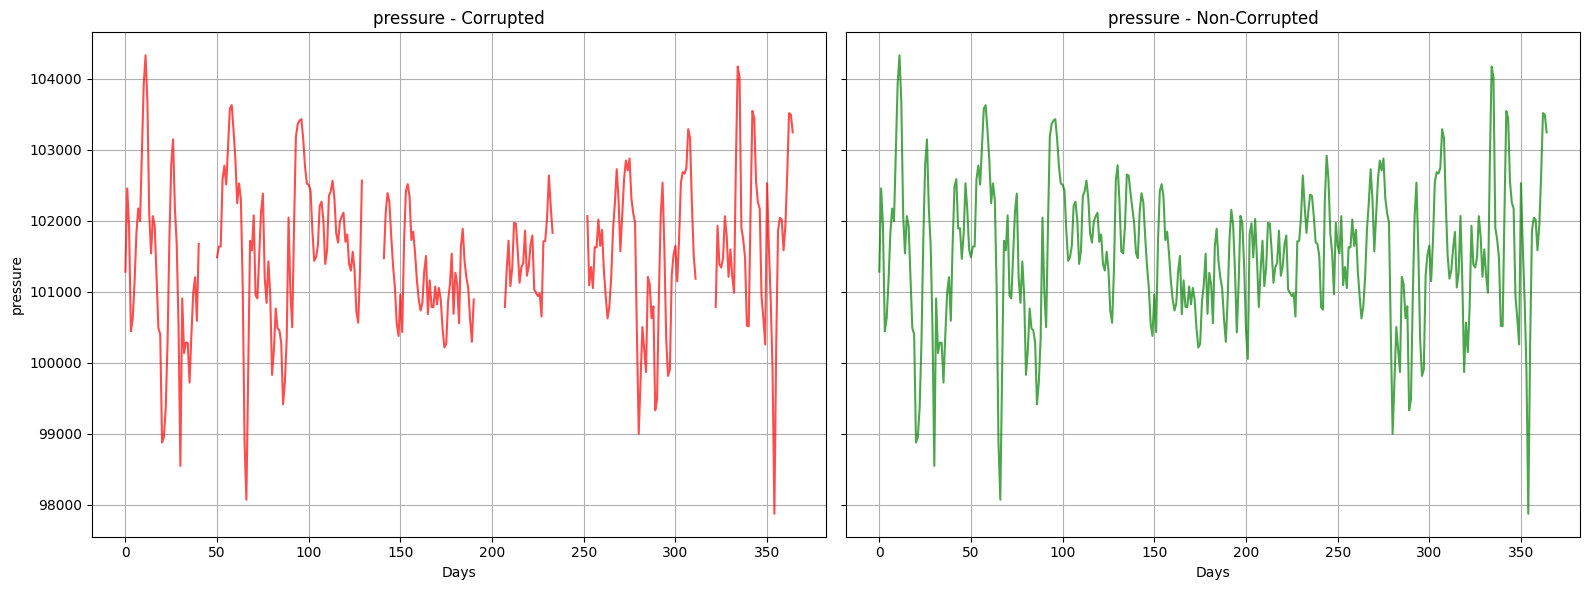

In [11]:
# first 365 entries
corrupted_data0_365 = corrupted_data0.head(365)
non_corrupted_data0_365 = non_corrupted_data0.head(365)

# Plot each variable side by side

for column in corrupted_data0_365.columns[1:]:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # Create side-by-side subplots

    #  corrupted data
    axes[0].plot(corrupted_data0_365[column], color='red', alpha=0.7)
    axes[0].set_title(f"{column} - Corrupted")
    axes[0].set_xlabel("Days")
    axes[0].set_ylabel(column)
    axes[0].grid()

    #  non corrupted data
    axes[1].plot(non_corrupted_data0_365[column], color='green', alpha=0.7)
    axes[1].set_title(f"{column} - Non Corrupted")
    axes[1].set_xlabel("Days")
    axes[1].grid()

    plt.tight_layout()
    plt.show()


- By plotting 365 entires wre can see what appears to be a seasonal dependence on certain features such as temperature, radiation and sunshine. This is going to be key to remember when we select a sequence length for feeding into an LSTM in order to capture there large scale patterns

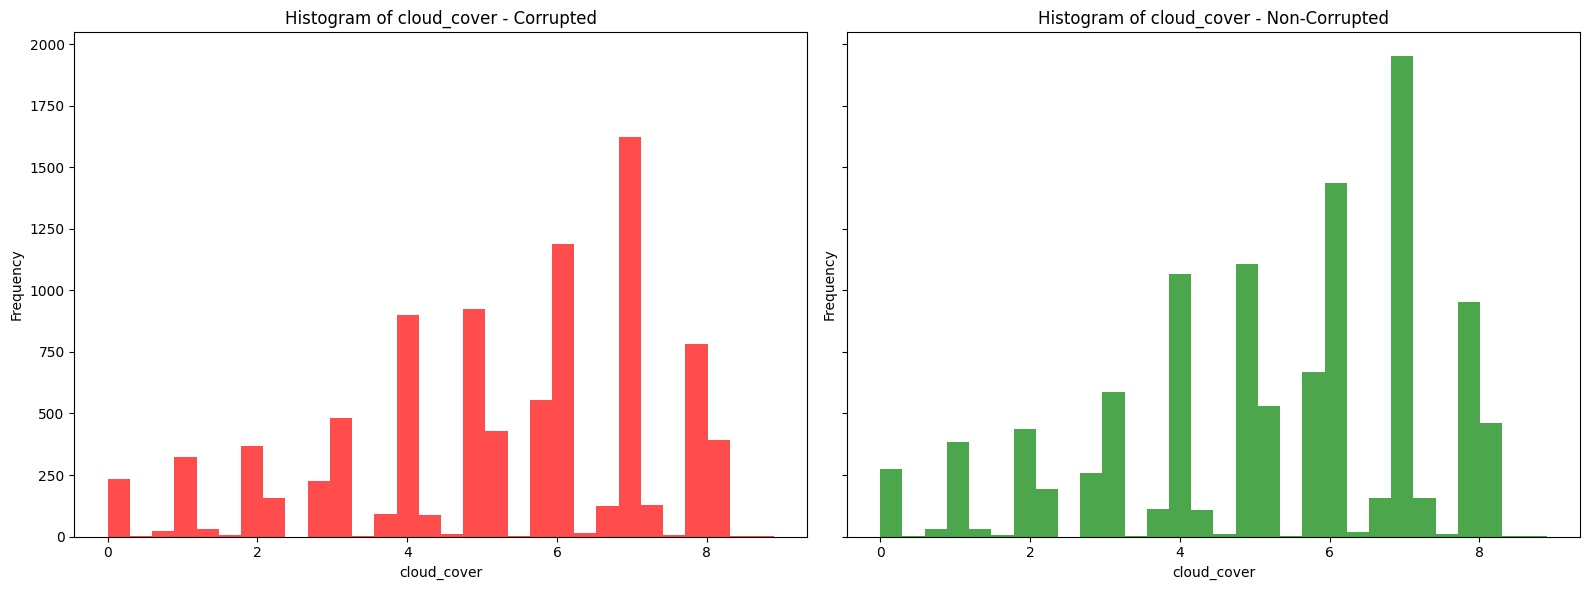

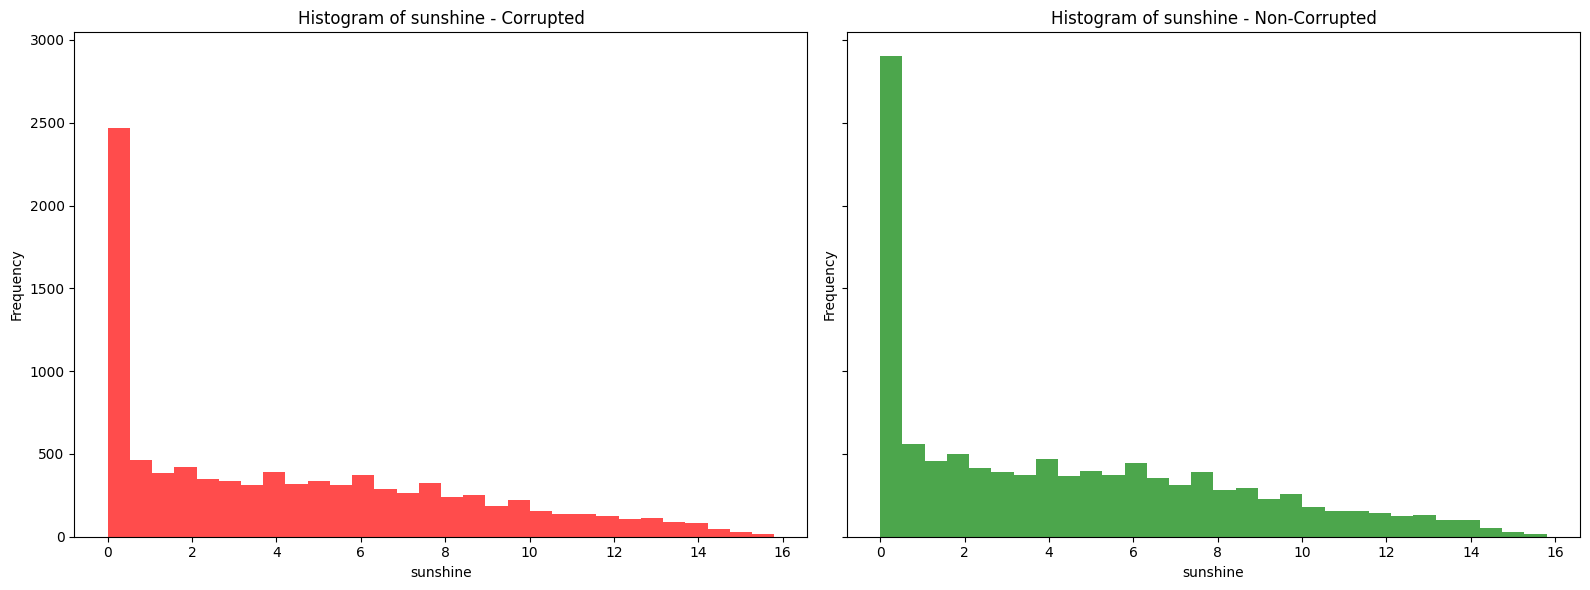

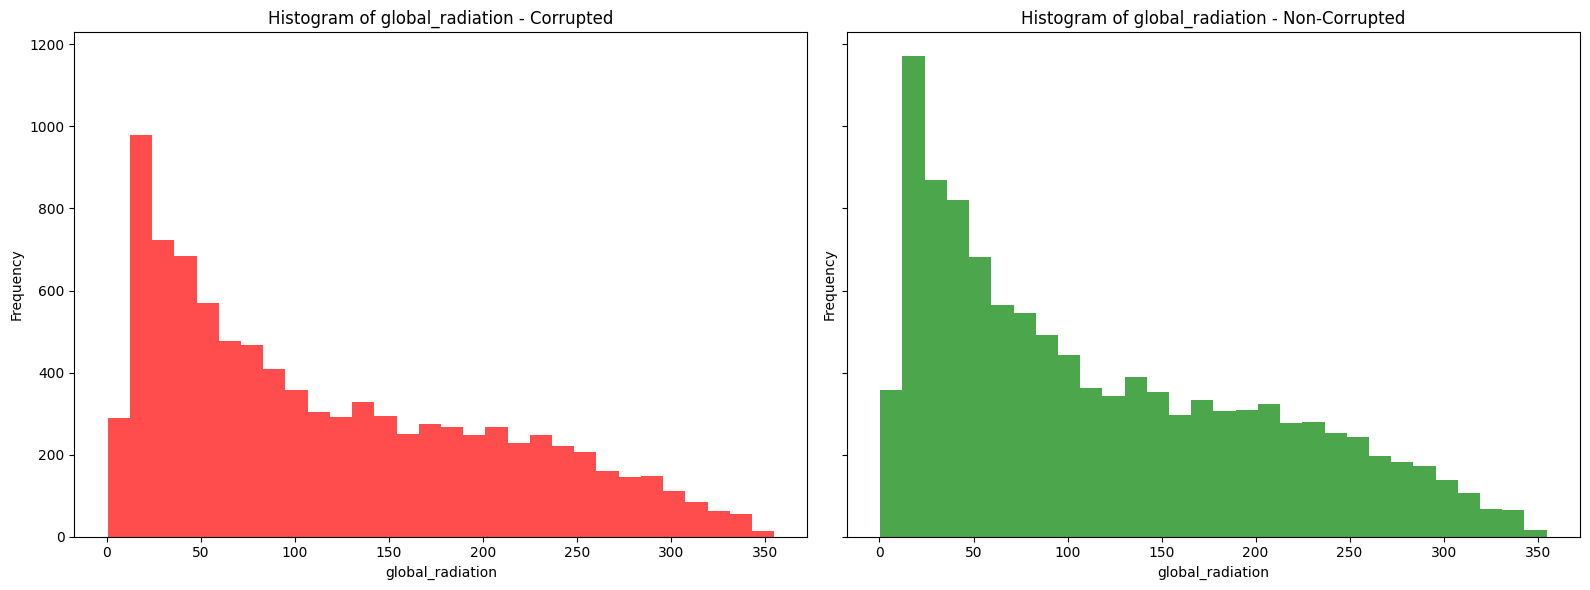

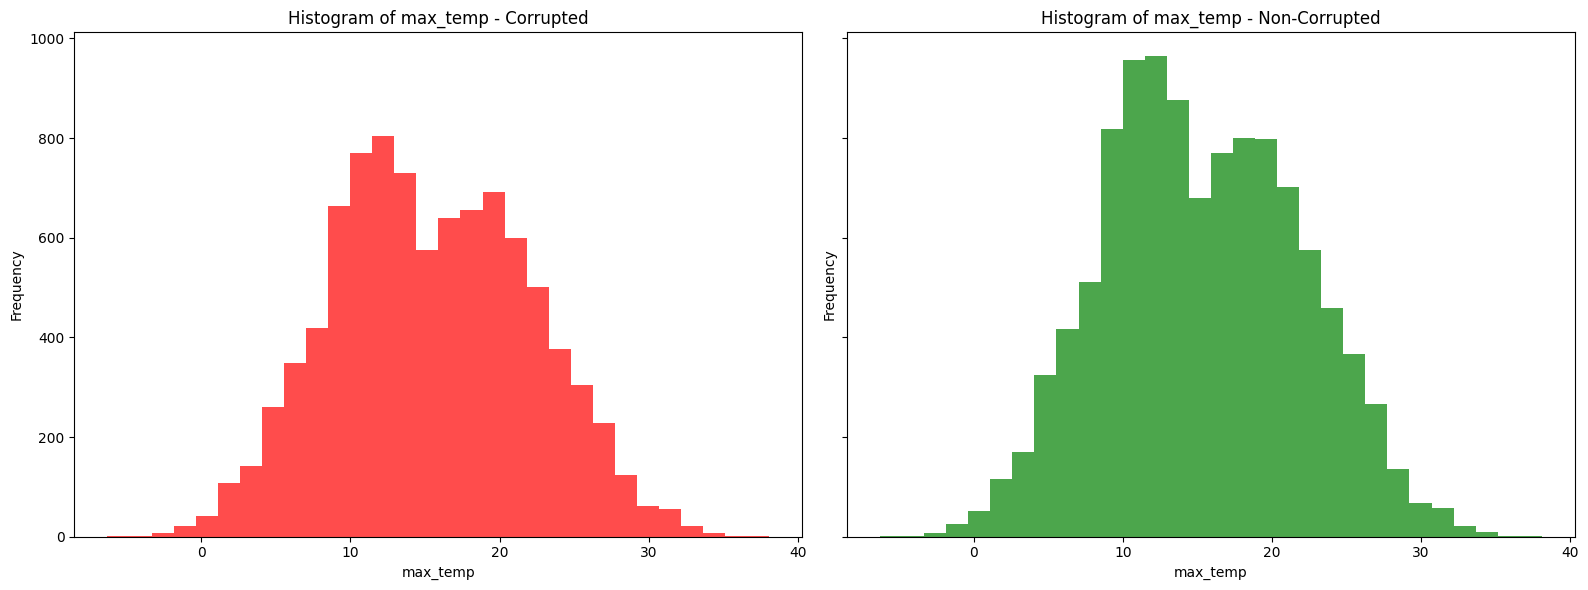

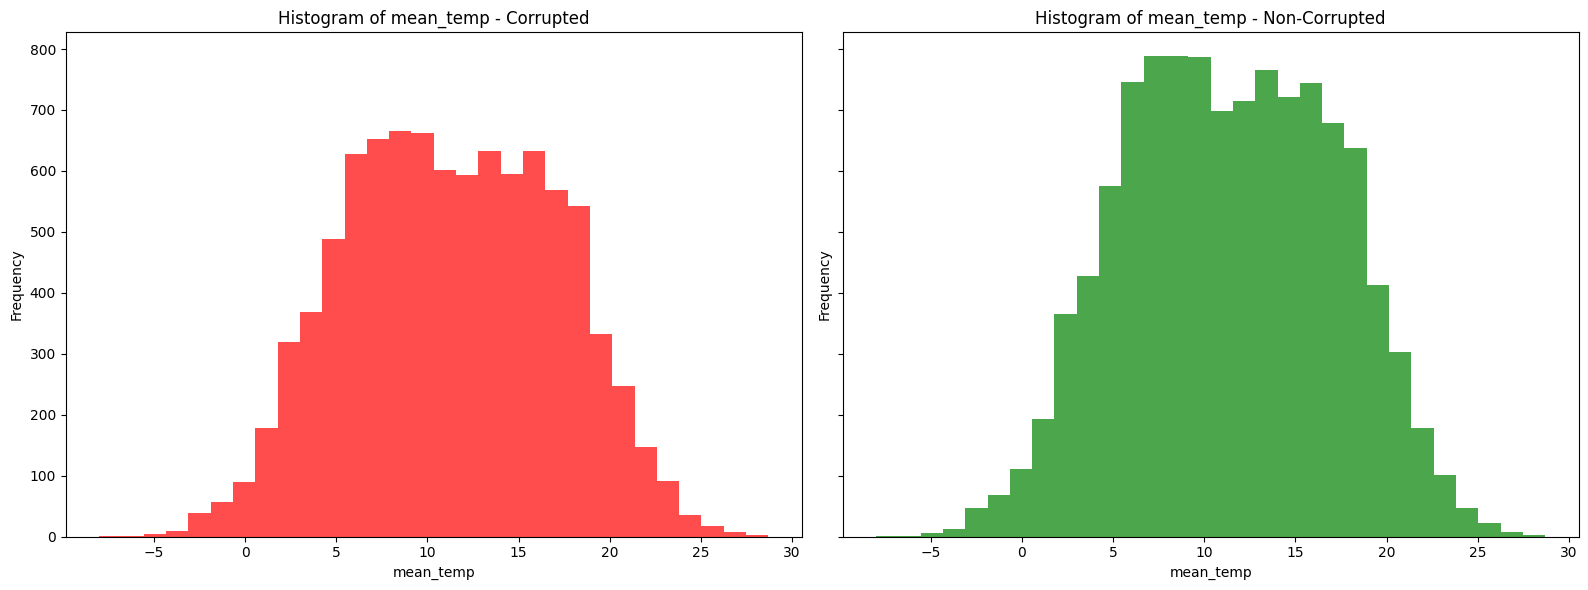

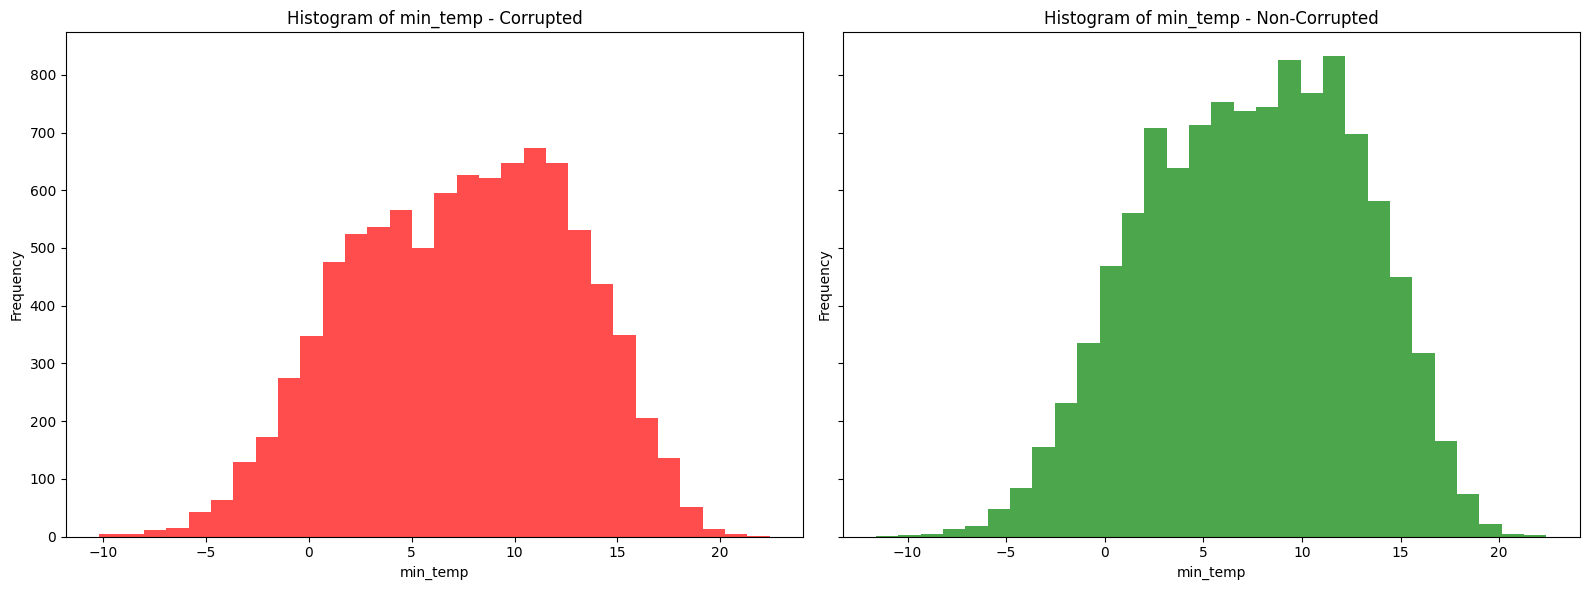

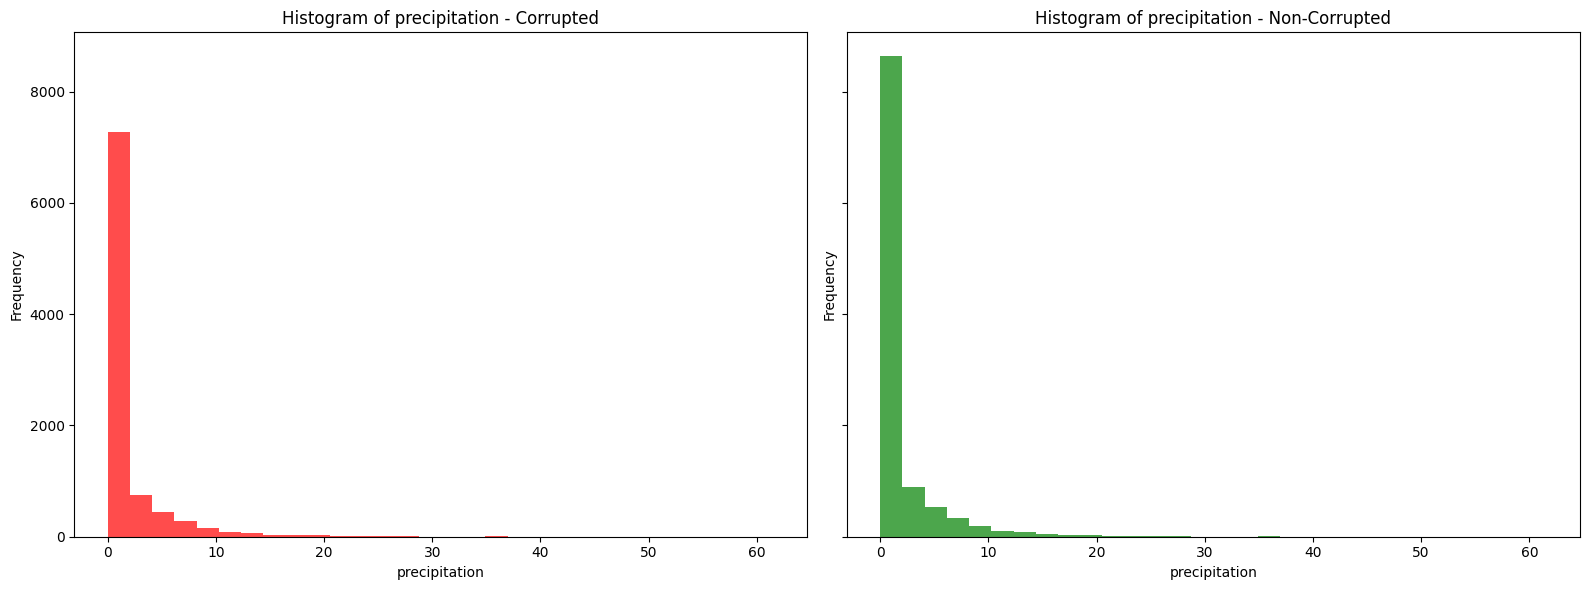

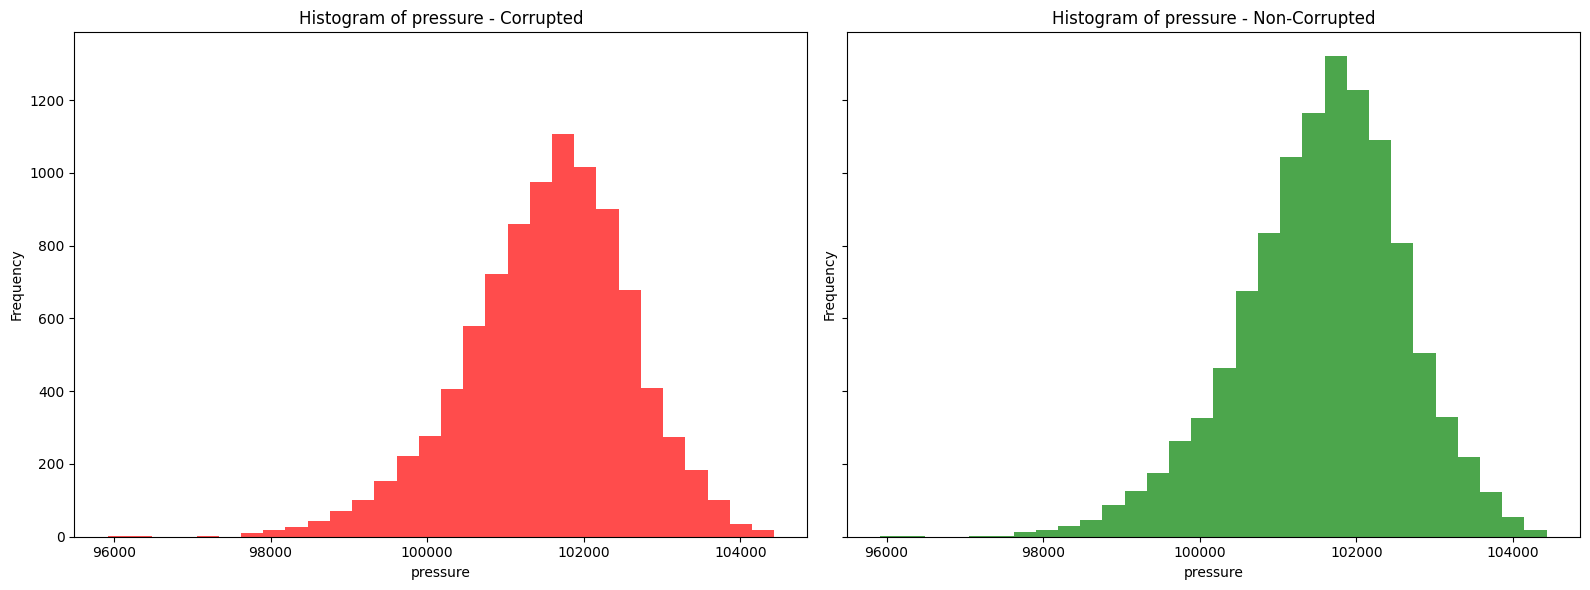

In [17]:
# Plot histograms for each variable
for column in all_corr_data.columns[1:]:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # Side-by-side plots

    # Corrupted data histogram
    axes[0].hist(all_corr_data[column], bins=30, color='red', alpha=0.7)
    axes[0].set_title(f"Histogram of {column} - Corrupted")
    axes[0].set_xlabel(column)
    axes[0].set_ylabel("Frequency")

    # Non corrupted data histogram
    axes[1].hist(all_non_corr_data[column], bins=30, color='green', alpha=0.7)
    axes[1].set_title(f"Histogram of {column} - Non-Corrupted")
    axes[1].set_xlabel(column)
    axes[1].set_ylabel("Frequency")


    plt.tight_layout()
    plt.show()

<br>

---

<br>

## **Question 2**  (25%)

Using the data loaded in **Question 1**, create a PyTorch `TensorDataset`, and create one `DataLoader` for the training set and another one for the test set.

The training loader should provide batches of weather data that have been corrupted, as well as the corresponding, paired un-corrupted batch of data. The test loader should provide batches of corrupted weather data, with no corresponding uncorrupted labels.

Using line plots, show here one batch from both the training and test datasets before and after corruption. Use different axis windows for input and label of the batch.

<br>



In [16]:
from re import M


# Split the data into features and target
X = all_corr_data.iloc[:, 1:]
y = all_non_corr_data.iloc[:, 1:]

#exclude date col
test = test_set.iloc[:, 1:]

X_array = X.to_numpy()
y_array = y.to_numpy()
test_array = test.to_numpy()

#scale the data
scaler = MinMaxScaler()
X_array = scaler.fit_transform(X_array)
y_array = scaler.transform(y_array)
test_array = scaler.transform(test_array)

#creating sequences for LSTM
def create_sequences(X, y, sequence_length):
    sequences_X, sequences_y = [], []
    for i in range(len(X) - sequence_length):
        seq_X = X[i:i+sequence_length]  # Sequence of inputs
        seq_y = y[i:i+sequence_length]  # Corresponding sequence of targets
        sequences_X.append(seq_X)
        sequences_y.append(seq_y)
    return torch.tensor(sequences_X, dtype=torch.float32), torch.tensor(sequences_y, dtype=torch.float32)

# Define sequence length
sequence_length = 180

# Create sequences
X_seq, y_seq = create_sequences(X_array, y_array, sequence_length)
print("Input Sequence Shape:", X_seq.shape)  # (num_samples, sequence_length, input_size)
print("Target Sequence Shape:", y_seq.shape)

test_seq, _ = create_sequences(test_array, test_array, sequence_length)
print("Test Input Shape:", test_seq.shape)  # (num_samples - sequence_length, sequence_length, input_size)

# Create a DataLoader for test data
test_dataset = TensorDataset(test_seq, test_seq)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Input Sequence Shape: torch.Size([10774, 180, 8])
Target Sequence Shape: torch.Size([10774, 180, 8])
Test Input Shape: torch.Size([3472, 180, 8])


In [17]:
dataset = TensorDataset(X_seq, y_seq)

# Compute sizes for training and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset = TensorDataset(X_seq[:train_size], y_seq[:train_size])
val_dataset = TensorDataset(X_seq[train_size:], y_seq[train_size:])

# Create DataLoaders without shuffling for time series
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)  # Keep sequential order
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# Create DataLoaders
batch_size = 32




In [18]:
#shapes of the data in the data loader
for X_batch, y_batch in train_loader:
    print("Input Shape:", X_batch.shape)
    print("Target Shape:", y_batch.shape)
    break

for X_batch, y_batch in val_loader:
    print("Input Shape:", X_batch.shape)
    print("Target Shape:", y_batch.shape)
    break

for X_batch, y_batch in test_loader:
    print("Input Shape:", X_batch.shape)
    break


Input Shape: torch.Size([32, 180, 8])
Target Shape: torch.Size([32, 180, 8])
Input Shape: torch.Size([32, 180, 8])
Target Shape: torch.Size([32, 180, 8])
Input Shape: torch.Size([32, 180, 8])


First batch from the Train set data Loader


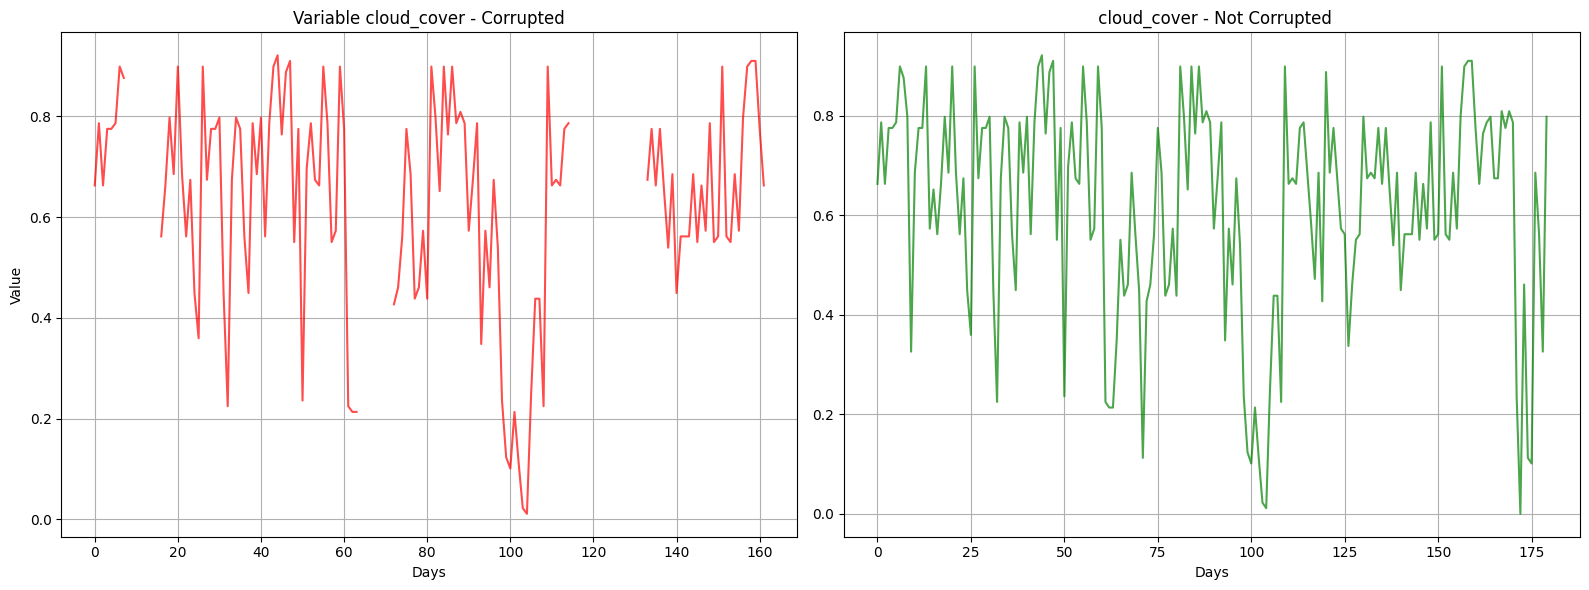

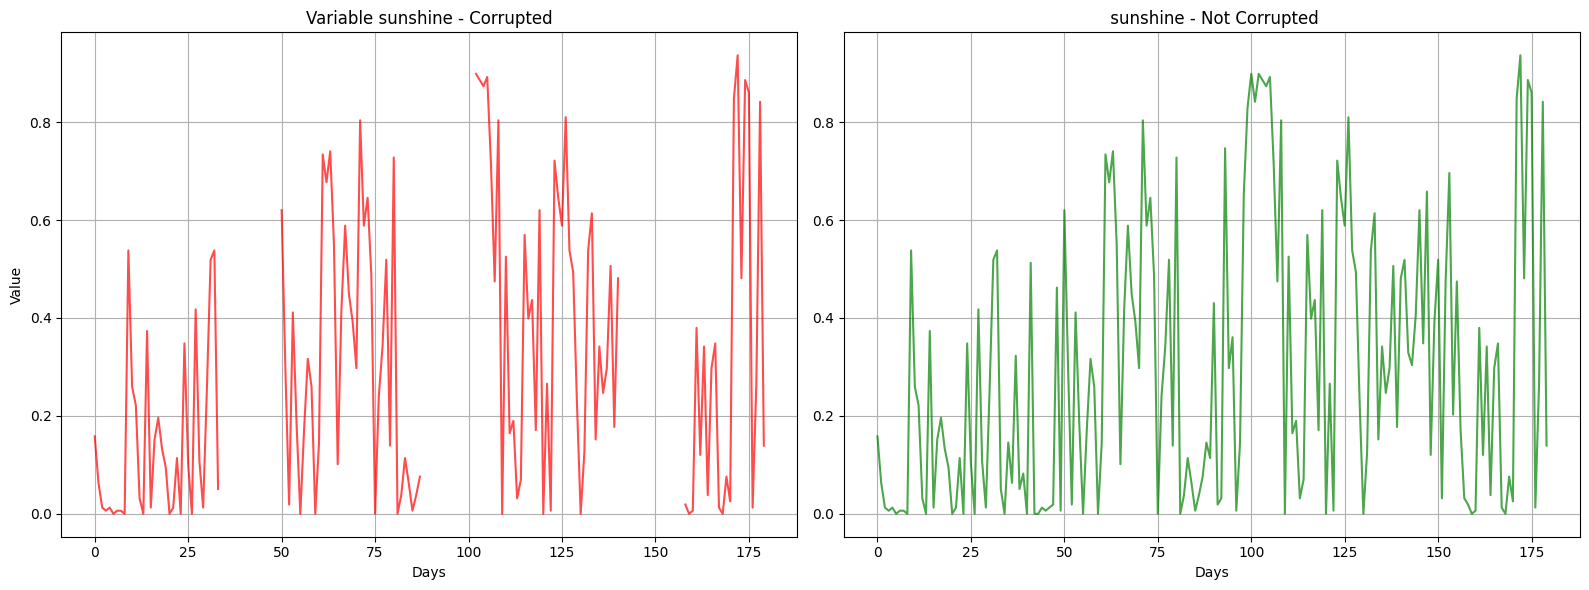

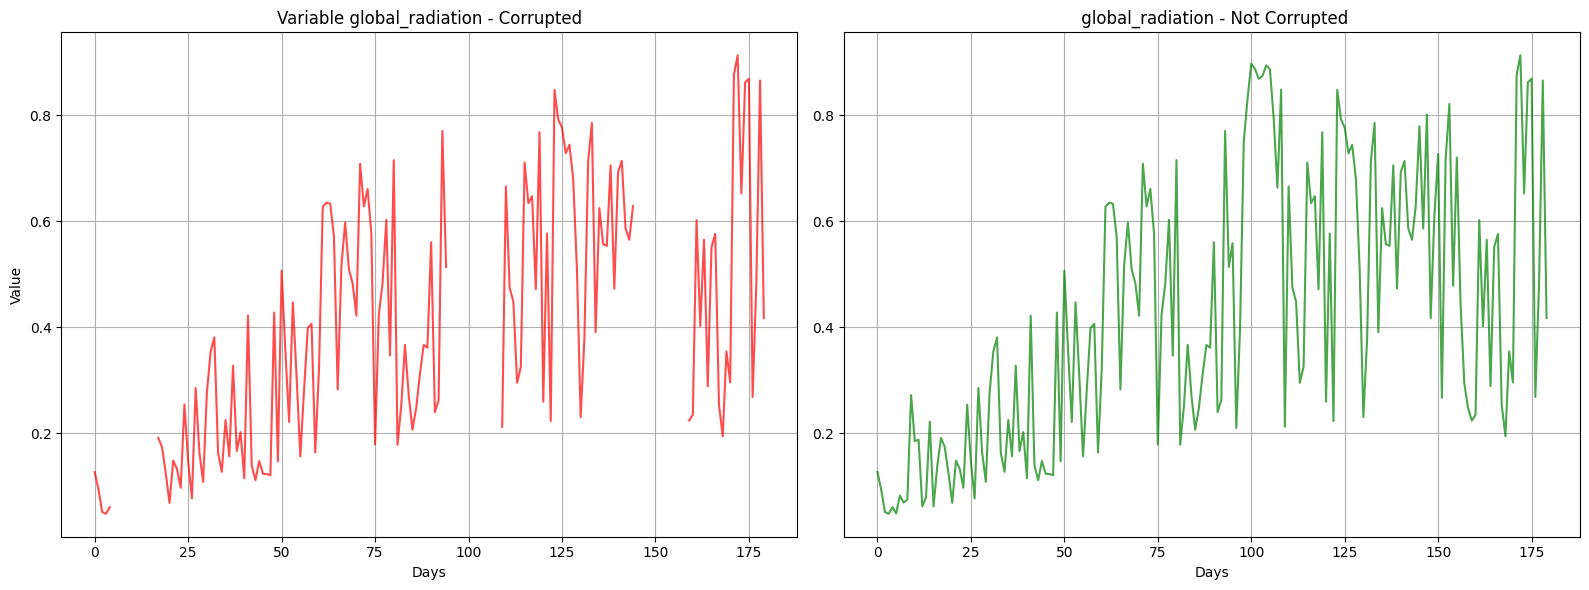

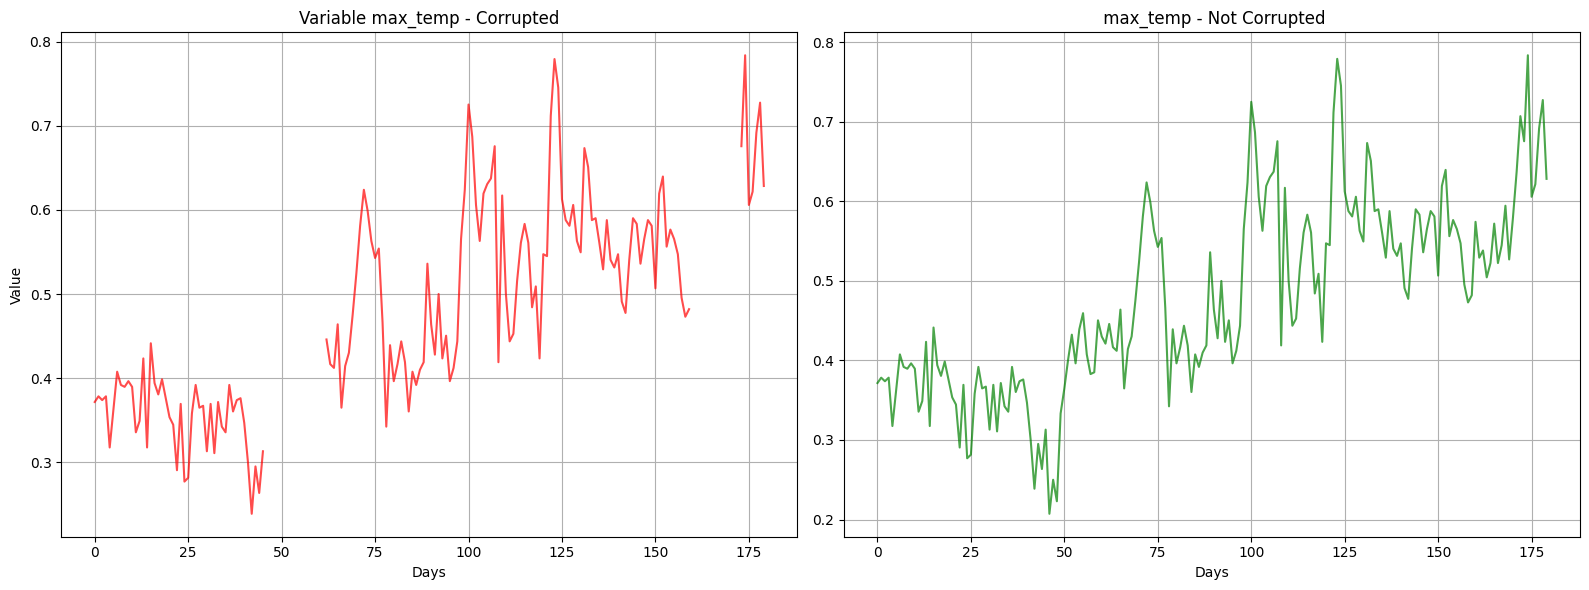

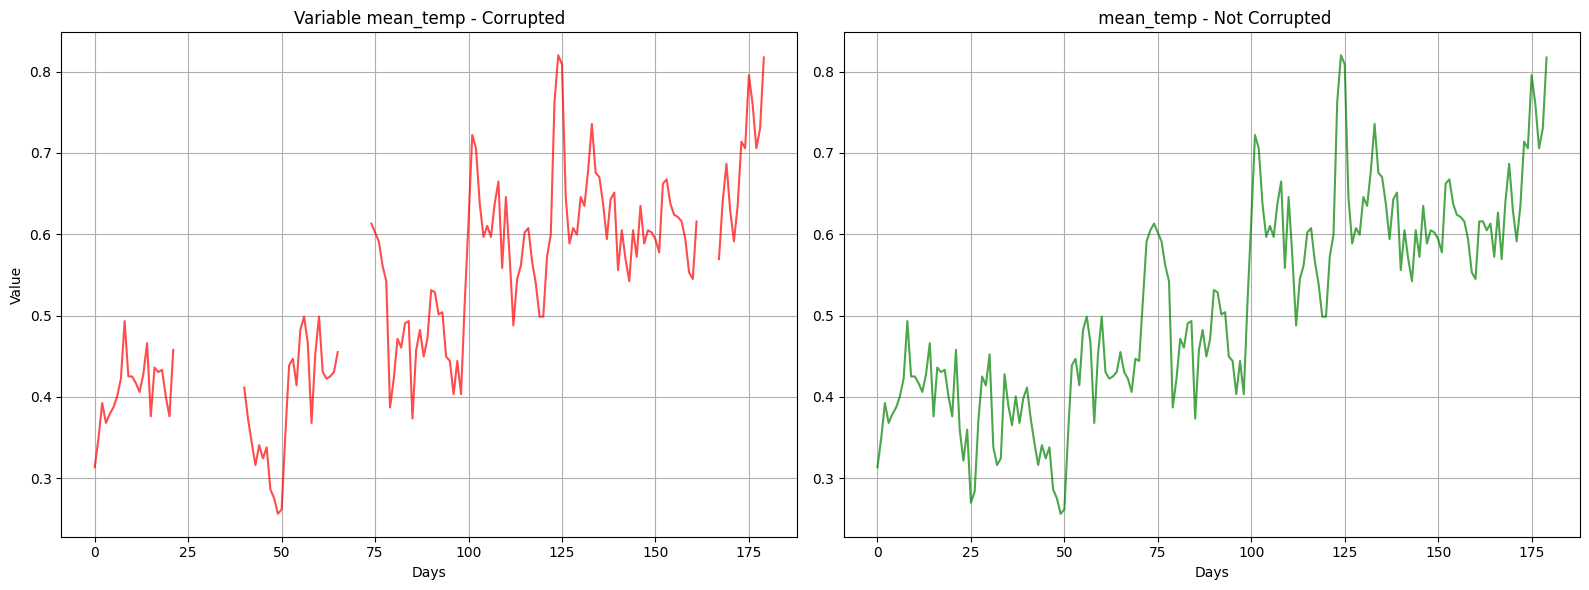

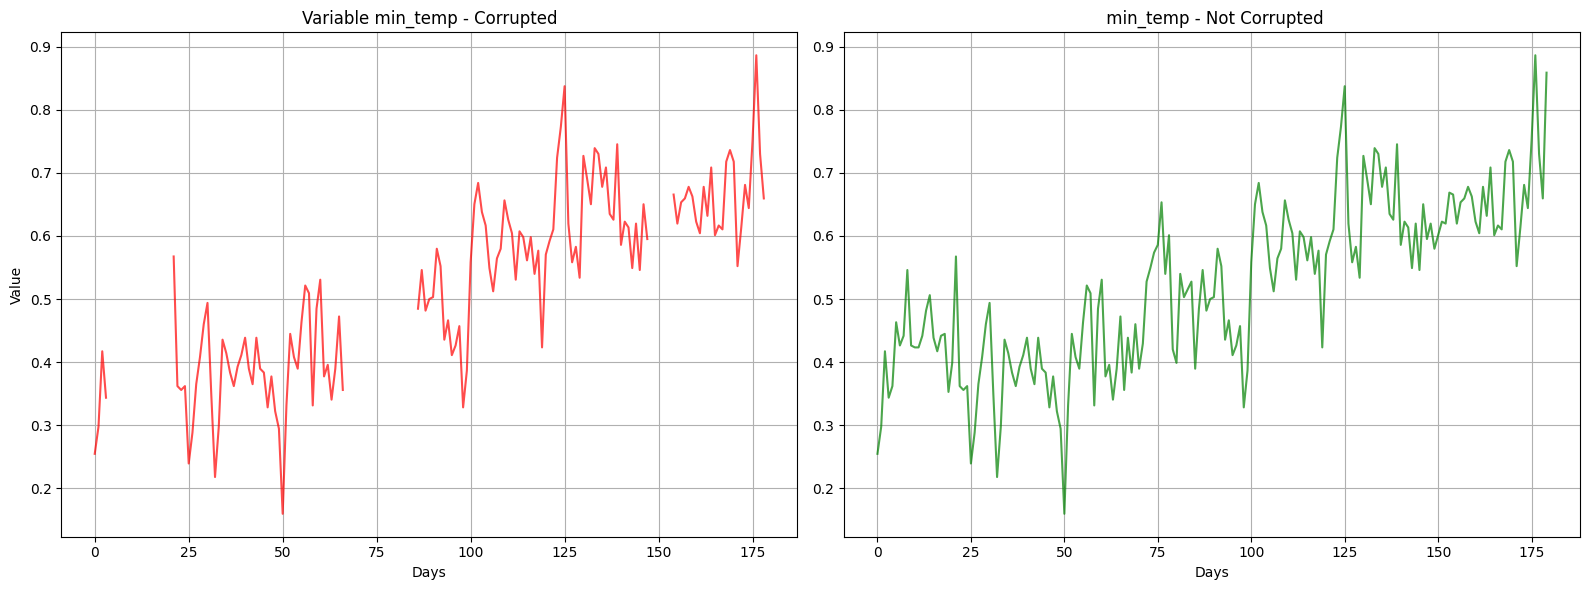

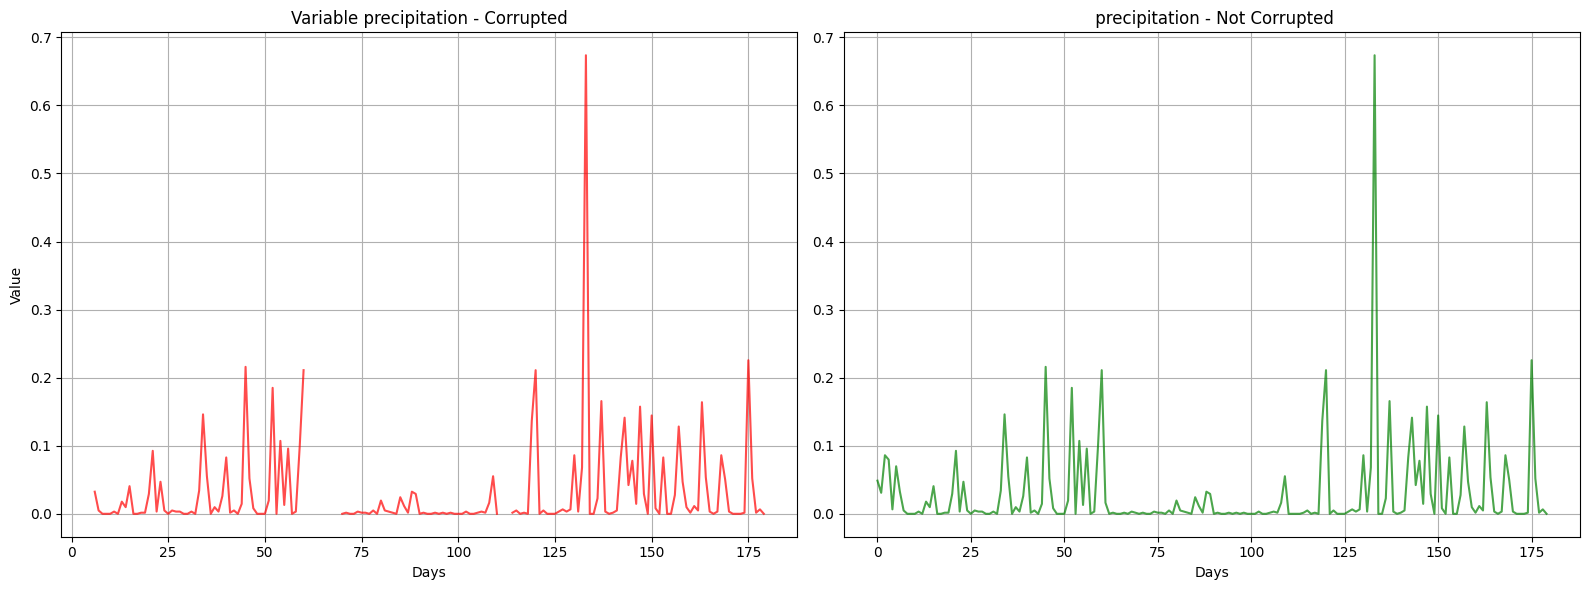

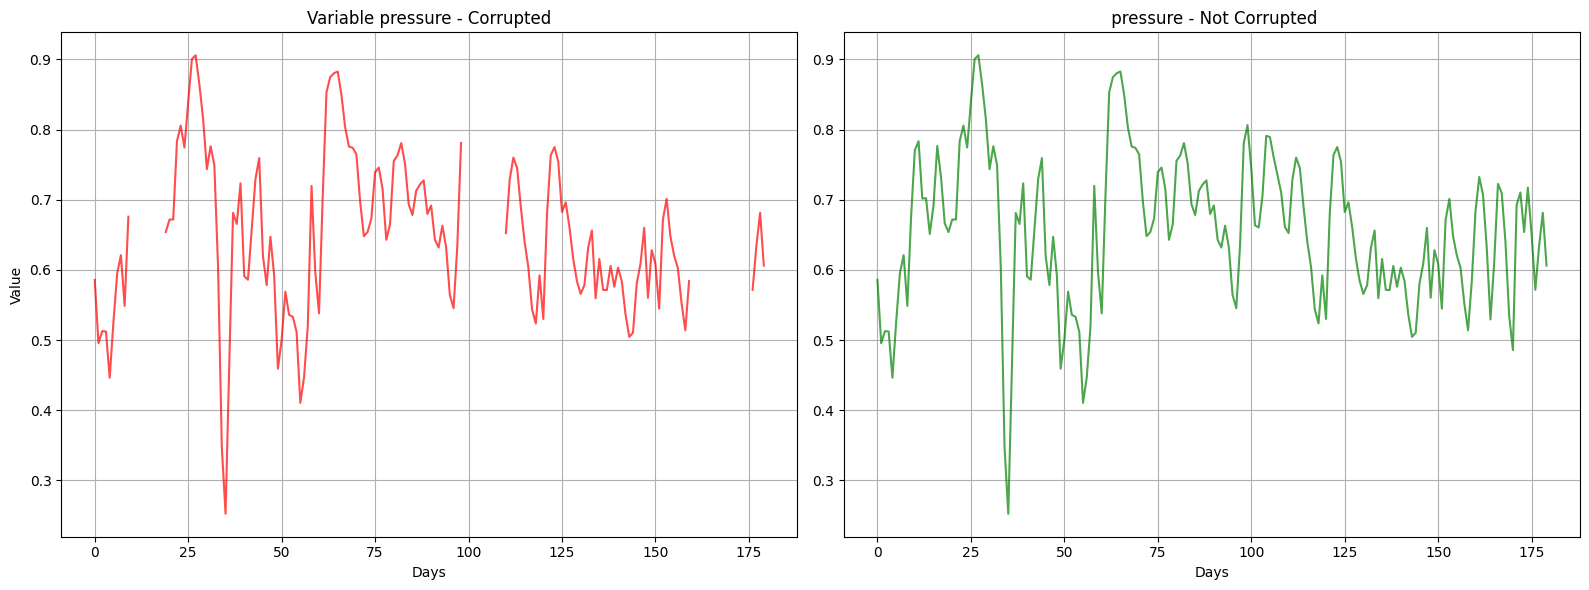

First batch from the test set data Loader


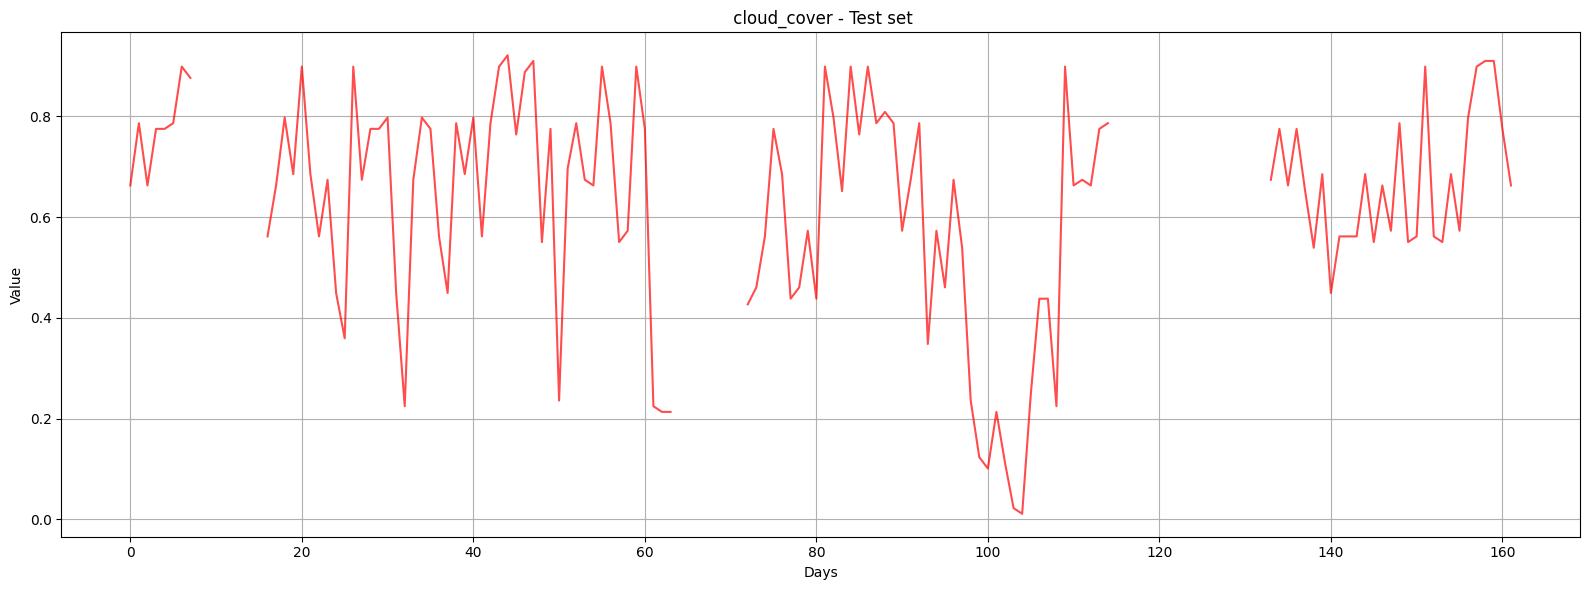

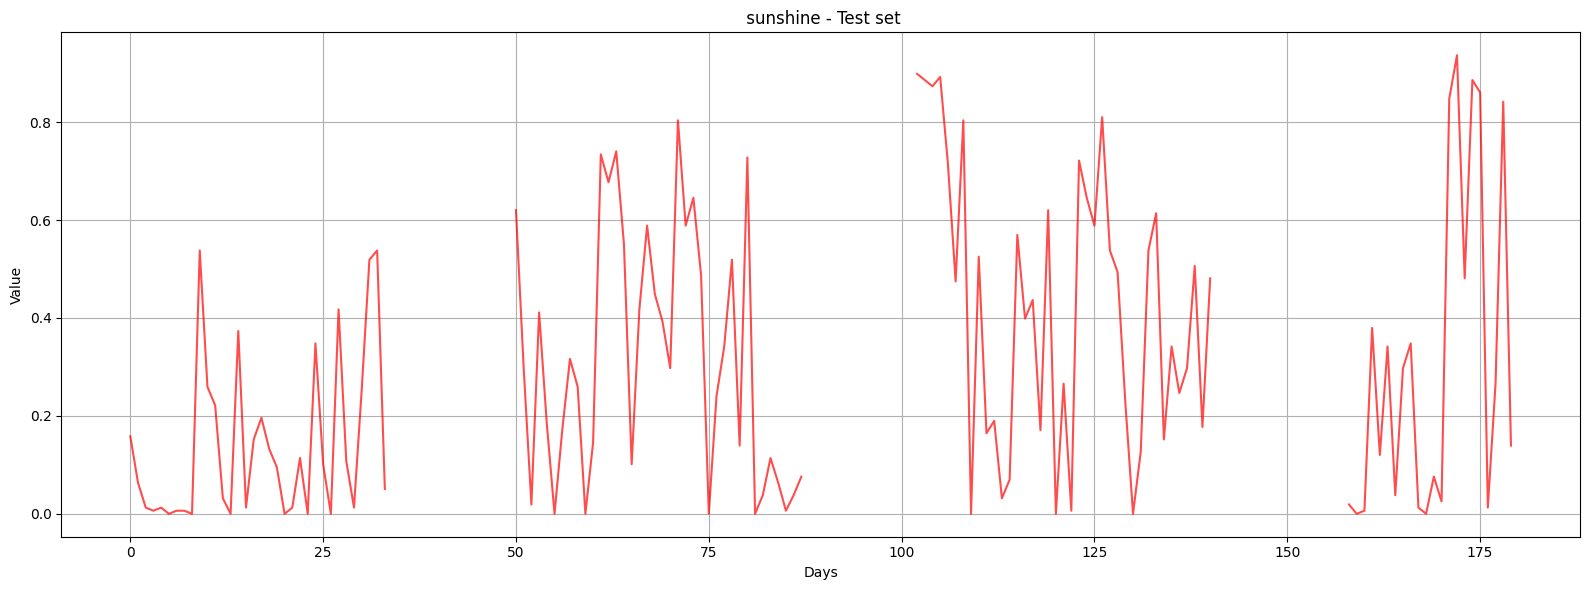

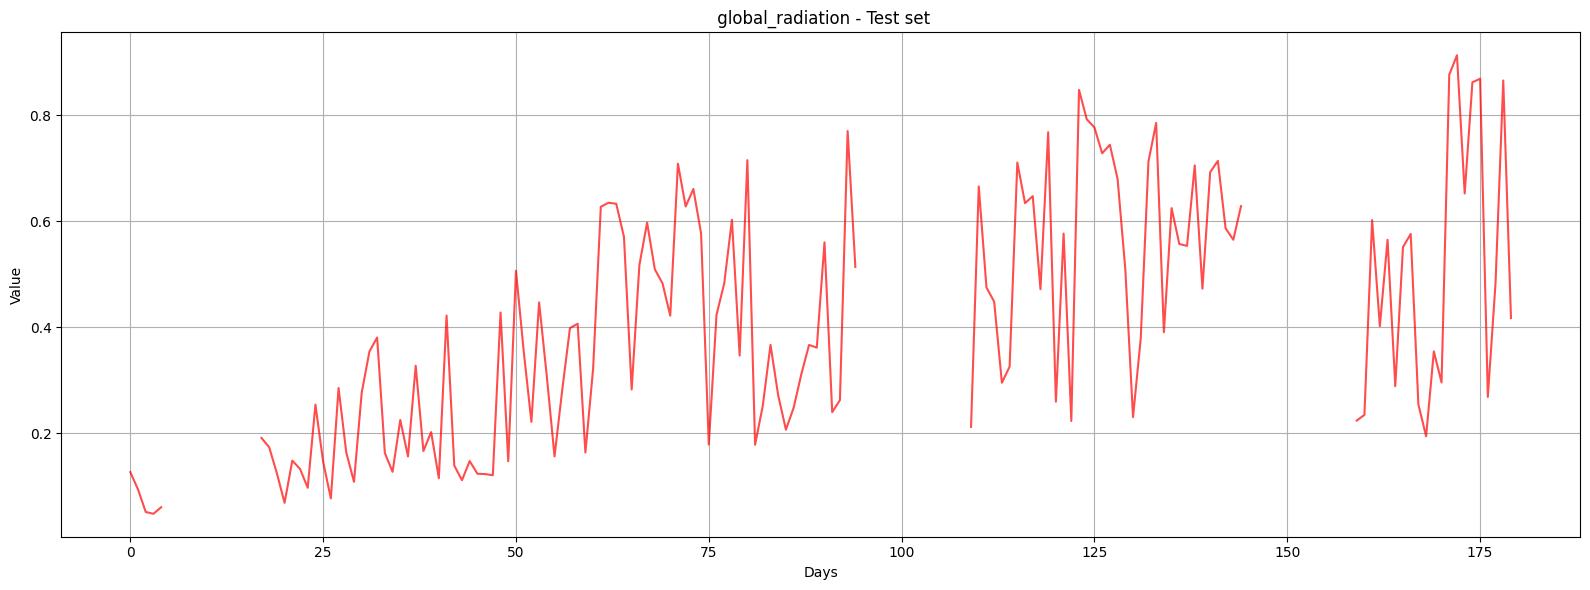

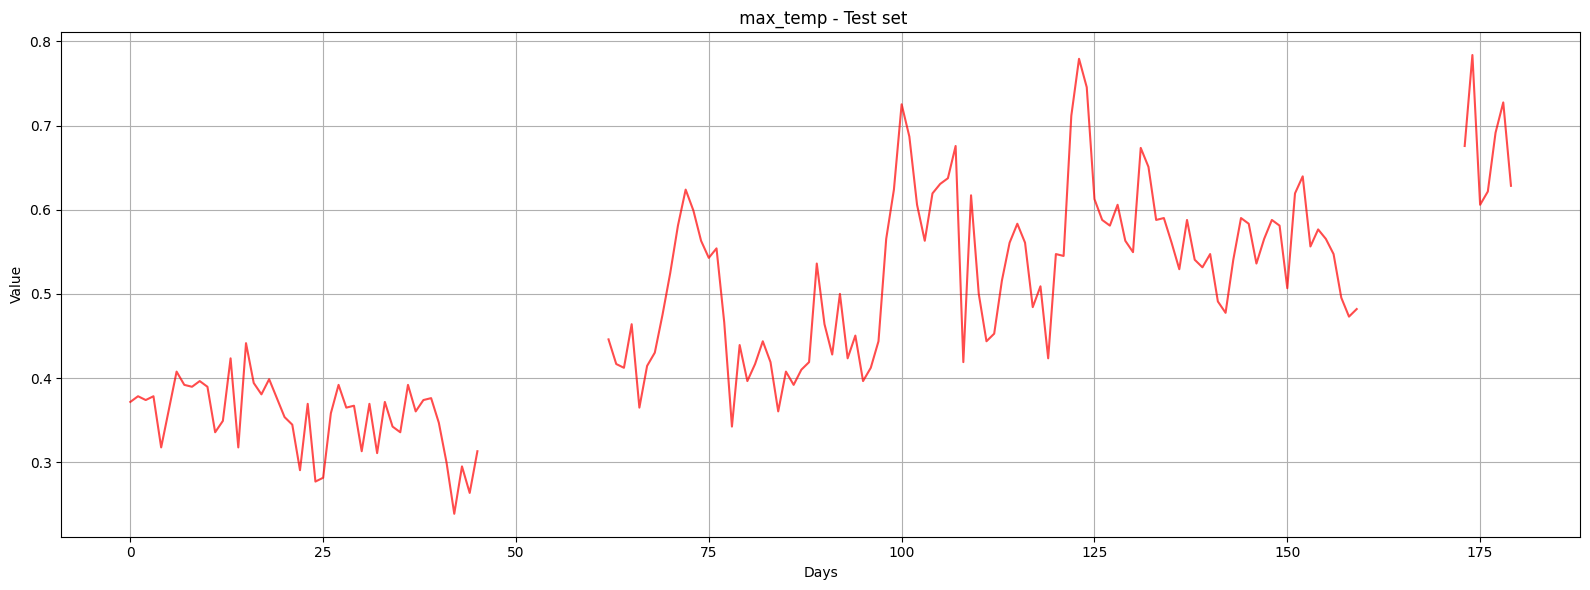

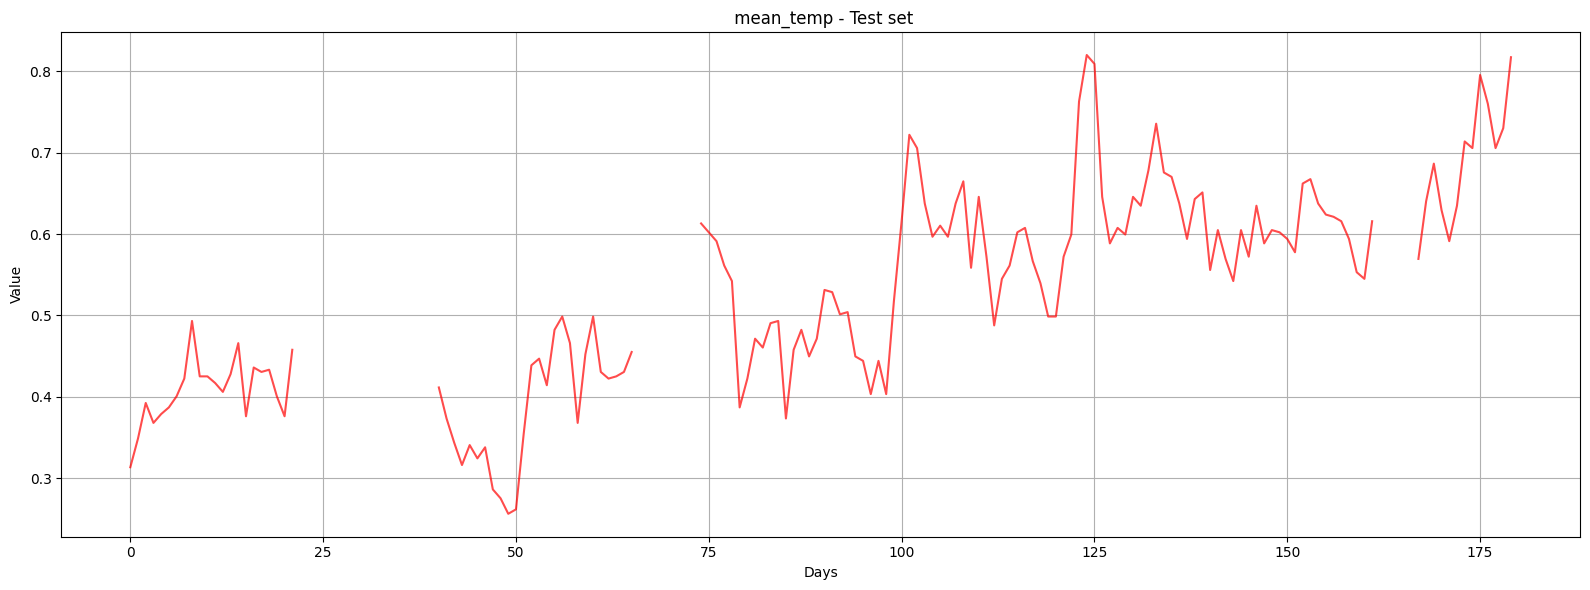

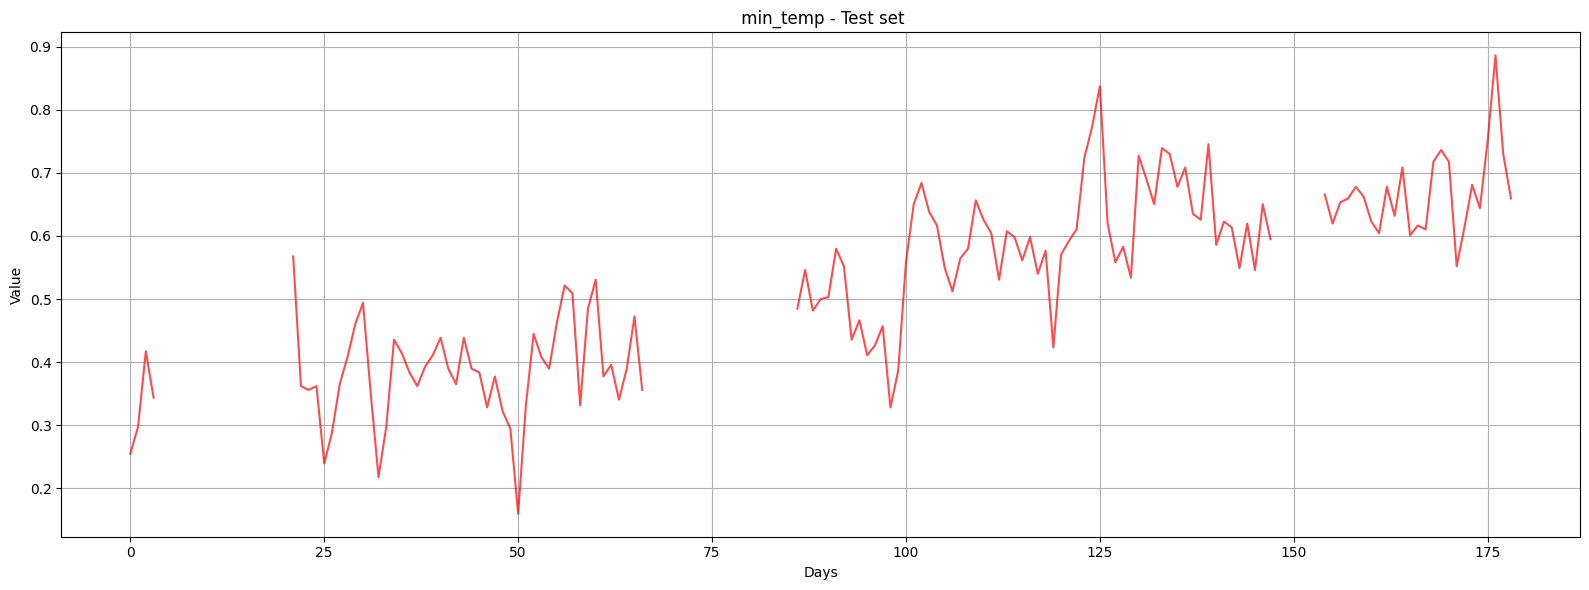

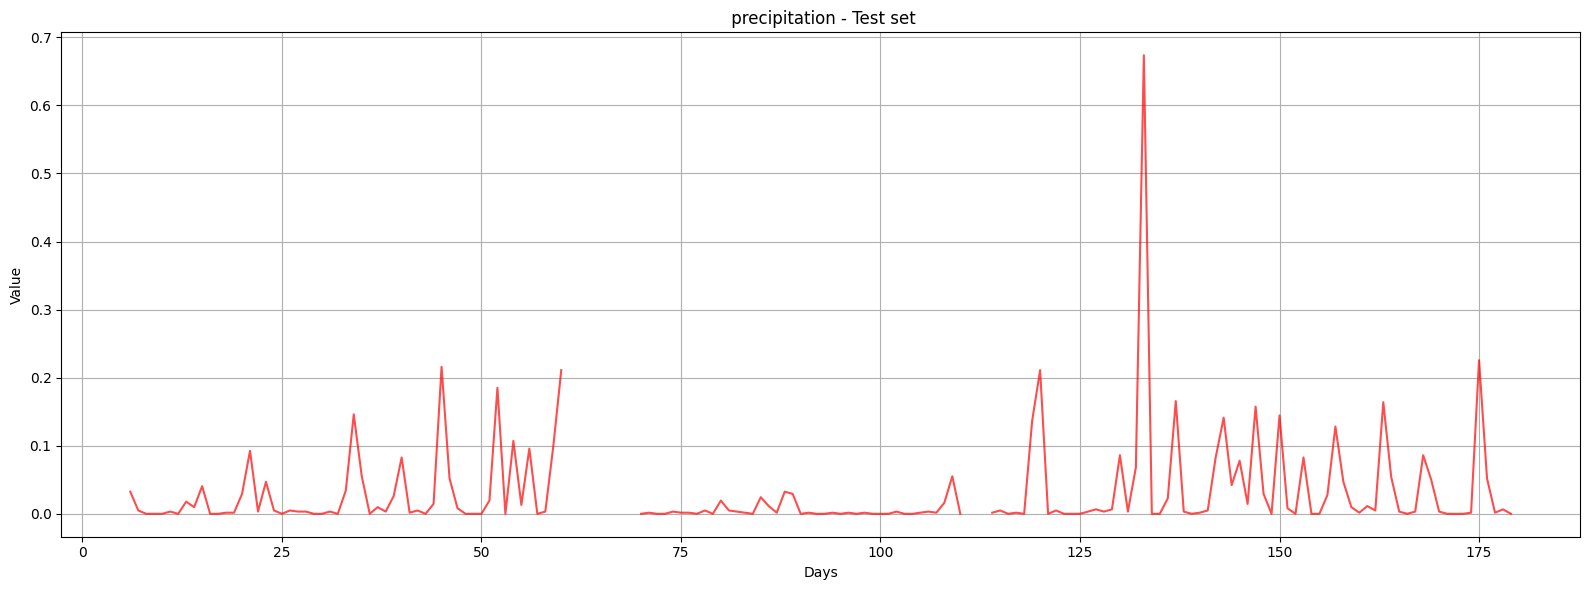

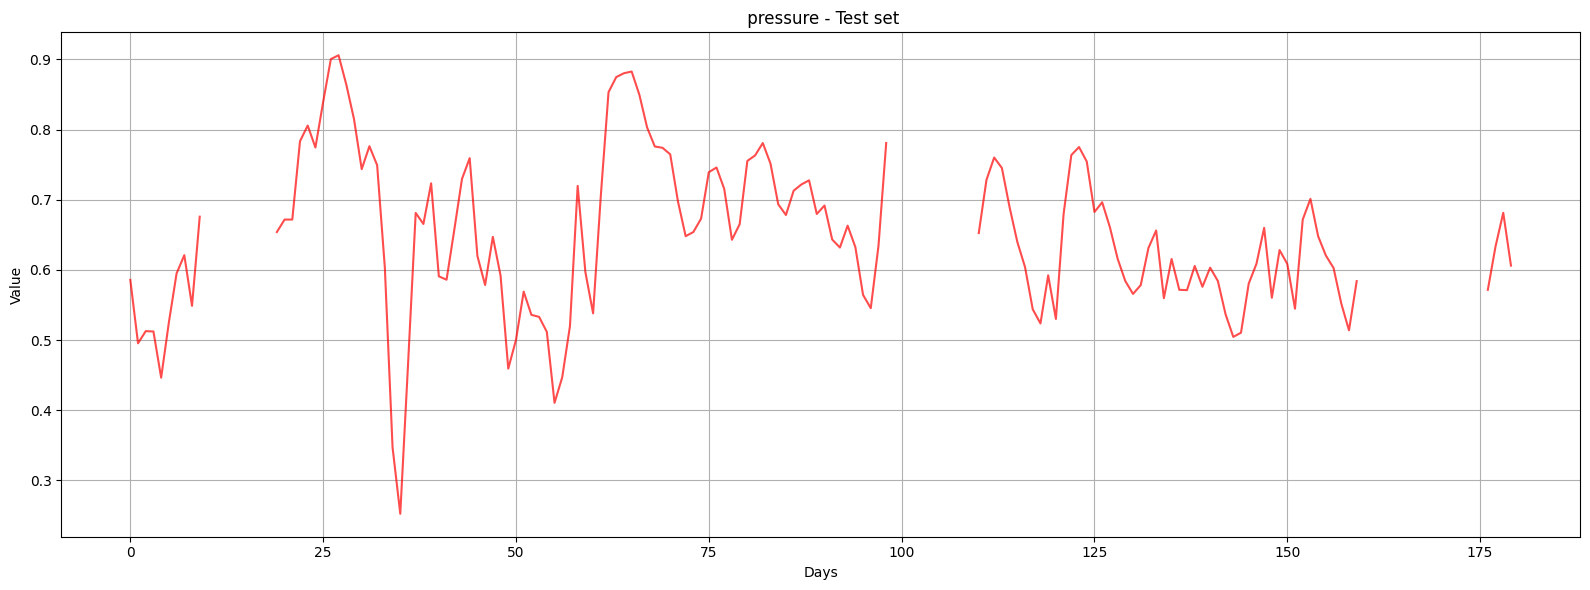

In [19]:
#first batch of data from training set and test set
data, target = next(iter(train_loader))


#remove the batch dimension
data = data[-1,:,:]
target = target[-1,:,:]



#to df with same column names
data_pd = pd.DataFrame(data.numpy(), columns=all_corr_data.columns[1:])
target_pd = pd.DataFrame(target.numpy(), columns=all_non_corr_data.columns[1:])

#plot the first batch of data and target side by side for each variable


print('First batch from the Train set data Loader')
for column in data_pd.columns:

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))


    # corrupted data
    axes[0].plot(data_pd[column], color='red', alpha=0.7)
    axes[0].set_title(f"Variable {column} - Corrupted")
    axes[0].set_xlabel("Days")
    axes[0].set_ylabel("Value")
    axes[0].grid()

    #  non corrupted data
    axes[1].plot(target_pd[column], color='green', alpha=0.7)
    axes[1].set_title(f" {column} - Not Corrupted")
    axes[1].set_xlabel("Days")
    axes[1].grid()

    plt.tight_layout()
    plt.show()




#test set
test = next(iter(test_loader))


#to df with same column names
test_pd = pd.DataFrame(data.numpy(), columns=test_set.columns[1:])
print('First batch from the test set data Loader')

for column in test_pd.columns:
    fig, axes = plt.subplots(1, 1, figsize=(16, 6))

    # corrupted data
    axes.plot(data_pd[column], color='red', alpha=0.7)
    axes.set_title(f" {column} - Test set")
    axes.set_xlabel("Days")
    axes.set_ylabel("Value")
    axes.grid()

    plt.tight_layout()
    plt.show()





- Above I organize the data into train, test and validation splits and create dataloaders for each, then plot the first sequence fromeach loader. There are a few key consdierations here. Scaling is vital here due to the differing magnitudes of each feature. Pressure is 5-6 orders of magnitude larger than the other features, which could introduce an unfair feature contribution and train the model with a bias. Initial tests using no scaling produced poor predictions that converged on a mean value of the data rather than larning patterns.

- Sequence length is also very important when using LSTMs and must be appropriate to the context of the data. In this case we are using weather data. In order to capture long term trends and patterns we should use a sequence length that can incorperate these.  A lot of the weather data provided likely has seasonal dependencies and so we should choose a sequence length long enough to capture these.

<br>

---

<br>

## **Question 3** (50%)

Using the dataset created in **Question 2**, design and train an architecture to recover the missing weather values of the provided test dataset.

Using line plots, show the test weather data with the missing values filled in using a different colour.

Additionally, save the test data with the missing values filled in into a file called `test_set_nogaps.csv` inside this repository. This file should have the same format as the original `test_set.csv` file, with the same number of rows and columns, the same row and column ordering, and the same column headings.

You have freedom to choose an architecture that you consider appropriate to solve this problem. However, you will need to train your chosen architecture as part of the assessment: **pre-trained networks are not allowed**.

You will be assessed by the quality of your predictions of the missing data values and additional marks will be given for originality in your network design choices. You should include, as part of your answer, a paragraph explaining the architecture you have chosen and any additional design choices and hyperparameters that have been important to build your solution.

This is an open-book assessment and you are encouraged to use resources online, including  tools like chatGPT. However, make sure to always mention the sources for your code and ideas, including websites, papers, and tools like chatGPT.

<br>


### Simple LSTM model

In [20]:
# Simple LSTM model


class TimeSeriesLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(TimeSeriesLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)
        # Fully connected layer
        out = self.fc(lstm_out[:, -1, :])  # predicted the next data point in the sequence
        return out


### Custom Loss Function Mask

- This loss function prioritizes filling in the corruption gaps by assigning a binary mask of 0 - true data and 1 - gaps in data. By doing this the model is only evaluated on how well it performs at filling in gaps rather than generating full datasets.

- The mask is used to ensure there are no NaN values in the dataset and so the model can learn to indetify which areas to prioritize in training through the custom loss function.

- Using the mask in model training adds an extra ipnut value for each input entry - doubling in the input size. It allows the modek to learn patterns associated with gaps in the data which may help predictions - although it is not neccessary to use it when training.

In [21]:
def masked_mse_loss(predictions, targets, mask):


    #invert mask - data -> 0 and corrupted -> 1 for loss function
    gap_mask = torch.logical_not(mask).float()
    loss = ((predictions - targets) ** 2)

    # no loss for predictions outside of gaps (loss*0)

    return (loss * gap_mask).sum() / gap_mask.sum()


- This cell trains the model and applies the mask. The input size is the number of features + mask, which allows the model to learn information about gaps. The num_layers and hidden_size were arbitrarily chose but perform well. Increasing the layers produced worse results and 100 epcohs was chose to ensure a conversgence.

In [1]:

# Hyperparameters
input_size = 16 # 8 features + binary  mask
hidden_size = 64
num_layers = 2
output_size = 8
num_epochs = 100
learning_rate = 0.01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, loss and optimizer
model = TimeSeriesLSTM(input_size, hidden_size, num_layers, output_size)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


def train_model(model, train_loader, val_loader, optimizer, epochs, device='cuda'):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        total_train_loss = 0

        for input_seq, target in train_loader:

            input_seq, target = input_seq.to(device), target.to(device)

            #applying mask
            mask = ~torch.isnan(input_seq)
            input_seq[torch.isnan(input_seq)] = 0  # Replace NaN with 0
            input_seq_with_mask = torch.cat((input_seq, mask.float()), dim=-1)

            # Forward pass with the target being the next data point with corresponding mask applied
            output = model(input_seq_with_mask)
            loss = masked_mse_loss(output, target[:, -1, :], mask[:, -1, :])

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        # Compute average training loss for the epoch
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for input_seq, target in val_loader:
                # Move data to the appropriate device
                input_seq, target = input_seq.to(device), target.to(device)

                #applying mask
                mask = ~torch.isnan(input_seq)
                input_seq[torch.isnan(input_seq)] = 0
                input_seq_with_mask = torch.cat((input_seq, mask.float()), dim=-1)

                output = model(input_seq_with_mask)


                # Calculate validation loss
                loss = masked_mse_loss(output, target[:, -1, :], mask[:, -1, :])
                total_val_loss += loss.item()

        # Compute average validation loss for the epoch
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch}, Training Loss: {avg_train_loss:}, Val Loss: {avg_val_loss:}")

    # Plot training and validation losses
    plt.figure(figsize=(10, 6))
    plt.plot(range( epochs), train_losses, label='Training Loss')
    plt.plot(range(epochs), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

train_model(model, train_loader, val_loader, optimizer, num_epochs, device=device)

NameError: name 'torch' is not defined

The following funtions are used to apply the model to gaps in the data using the binary mask and make predictions on these values and plot the predictions of the filled gaps. For data where there is no corruption the binary mask ensures that this data is retained and only predictions on the areas where data is missing are used.

In [ ]:
def fill_gaps(model, input_seq, mask, device=device):
    input_seq = input_seq.to(device)
    mask = mask.to(device)

    input_seq[torch.isnan(input_seq)] = 0
    filled_seq = input_seq.clone()

    #looping over sequence
    for i in range(input_seq.size(1)):

        #identifying gaps in the data
        time_step_mask = mask[:, i, :]
        missing_indices = time_step_mask == 0

        #applying mask to highlight gaps
        if missing_indices.any():
            input_to_model = filled_seq[:, :i + 1, :]
            mask_up_to_t = mask[:, :i + 1, :]
            input_with_mask = torch.cat((input_to_model, mask_up_to_t.float()), dim=-1)

            #predicting with mask
            with torch.no_grad():
                predictions = model(input_with_mask)

            #match the gaps with the mask value
            filled_seq[:, i, :][missing_indices] = predictions[missing_indices]

    return filled_seq

#eval mode
model.eval()
model.to(device)

#initialize output
filled_sequences = []

with torch.no_grad():
    for input_seq, _ in val_loader:
        input_seq = input_seq.to(device)
        mask = ~torch.isnan(input_seq)

        #actual predicting using fill_gaps function
        filled_seq = fill_gaps(model, input_seq, mask, device=device)
        filled_seq = filled_seq.cpu().numpy()
        filled_sequences.append(filled_seq)

#output of all filled sequences - note there are repeated values due to sliding window
filled_sequences = np.concatenate(filled_sequences, axis=0)



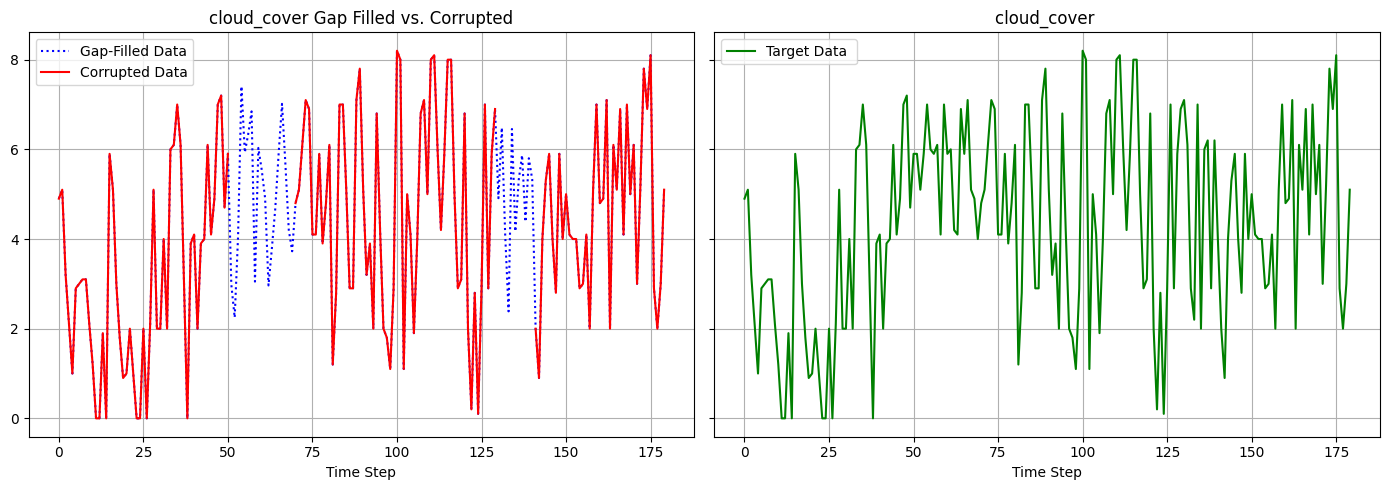

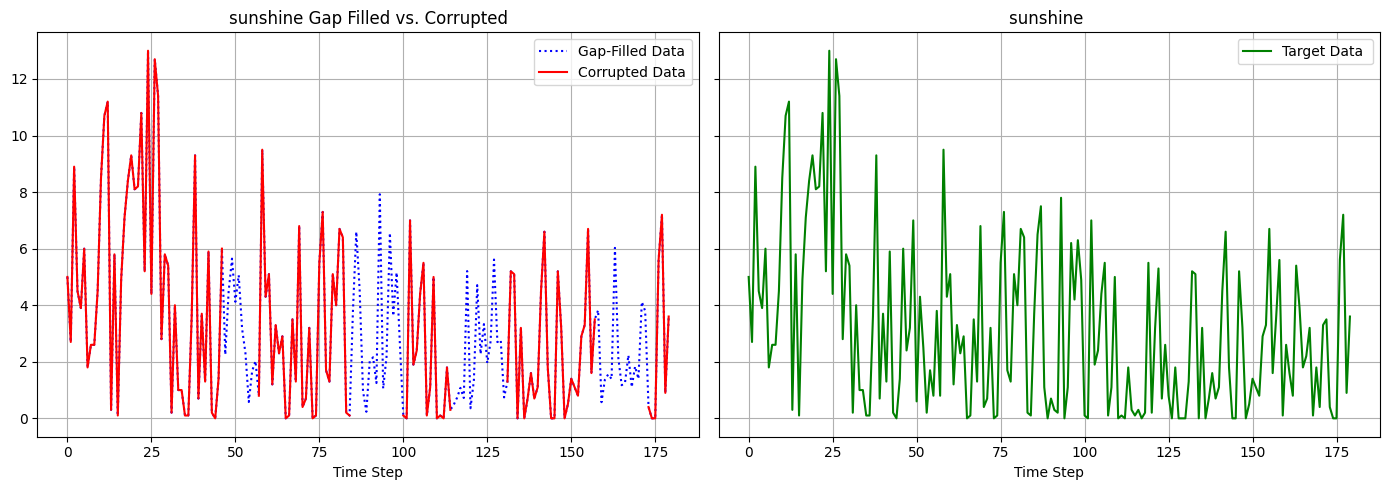

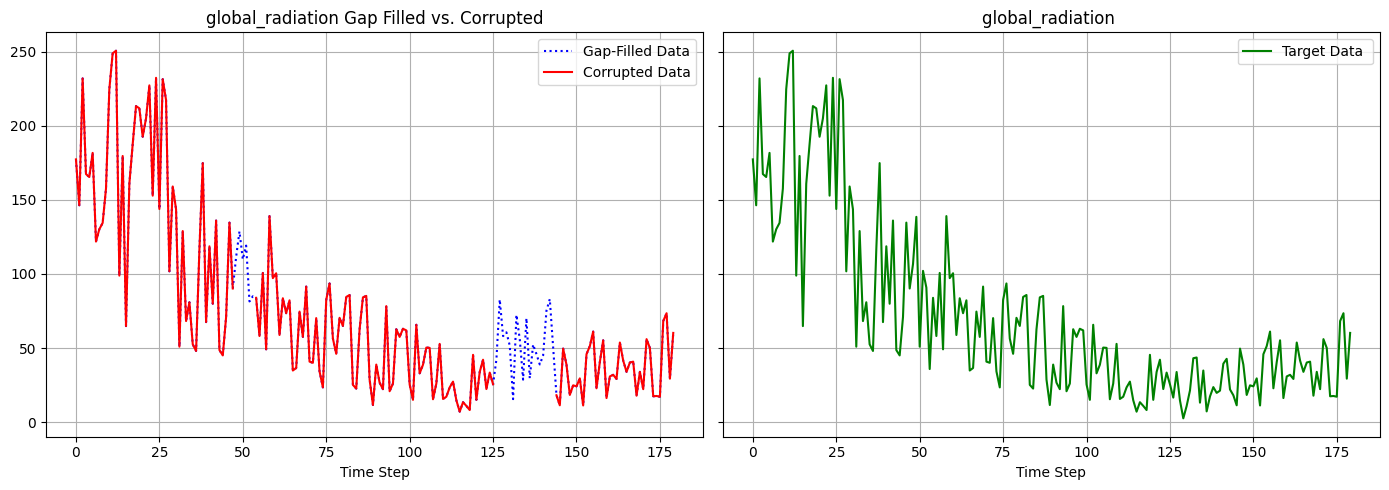

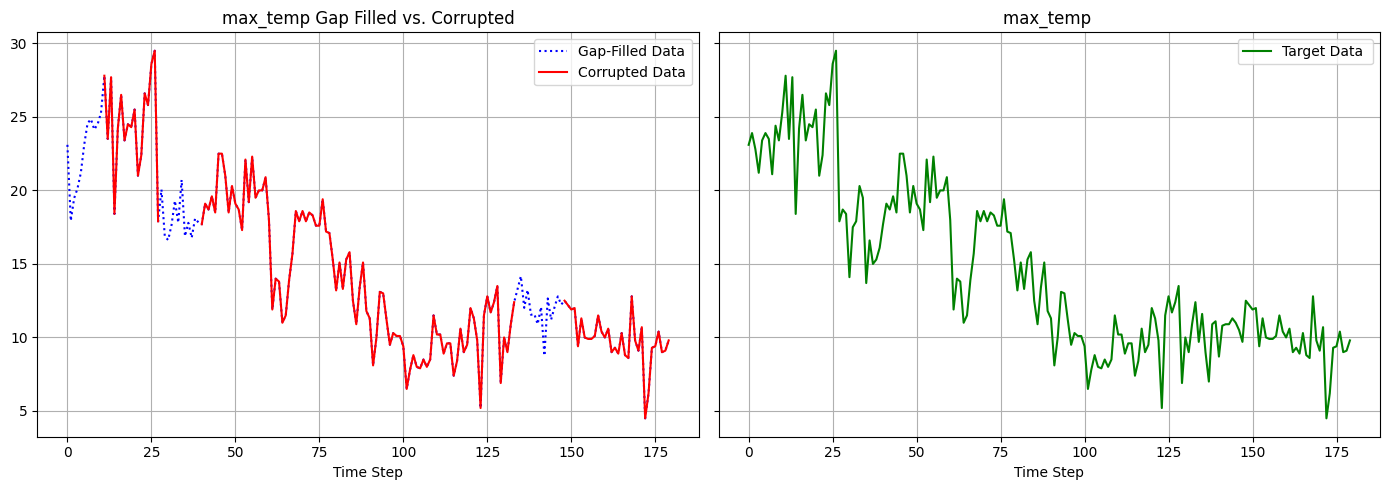

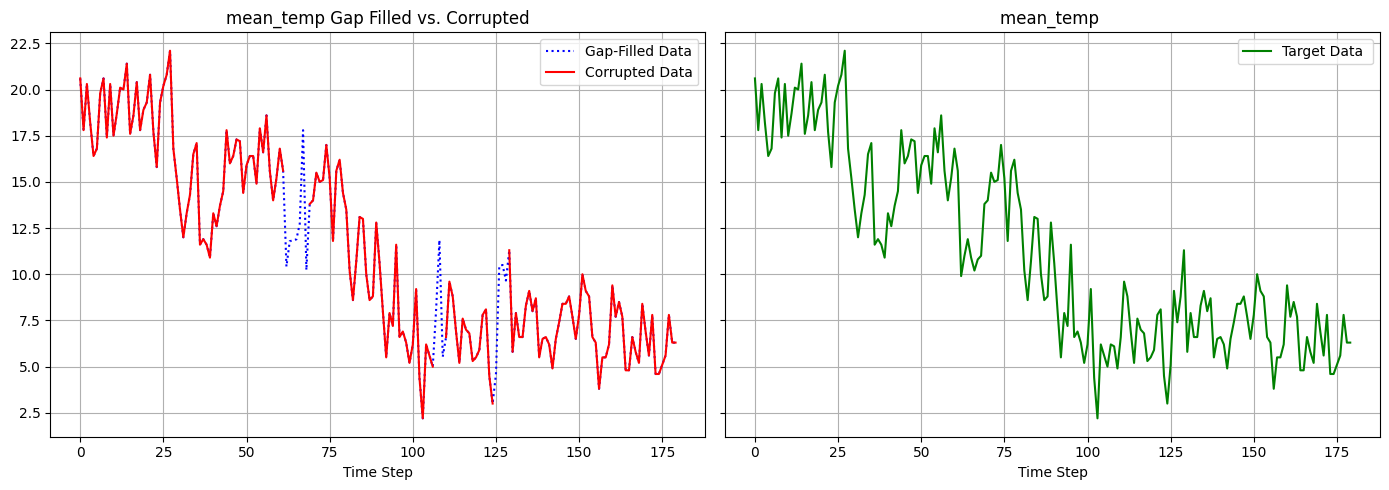

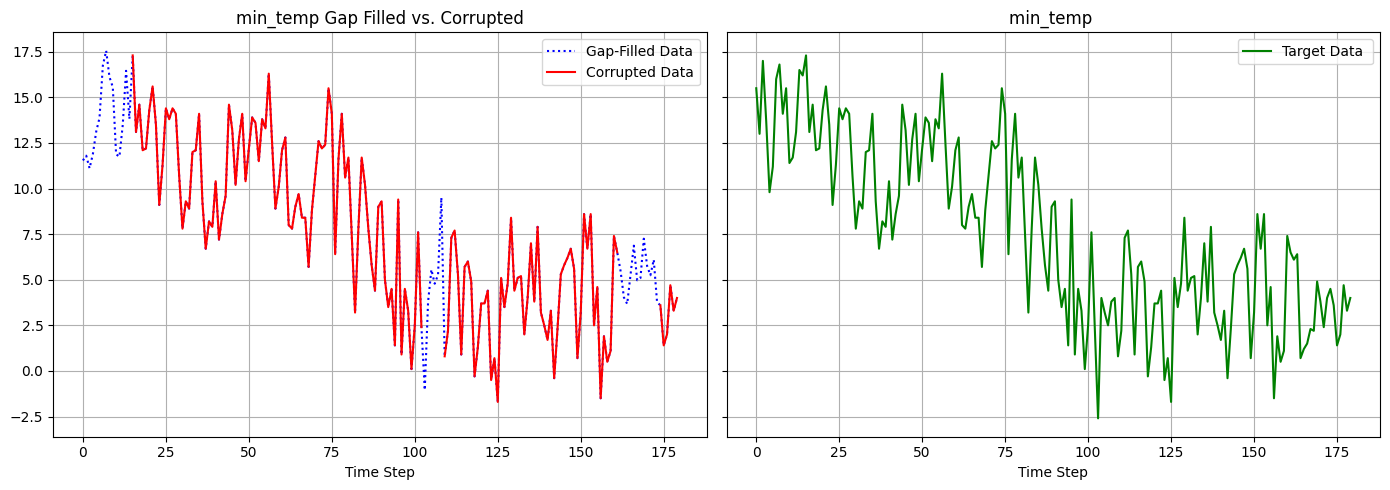

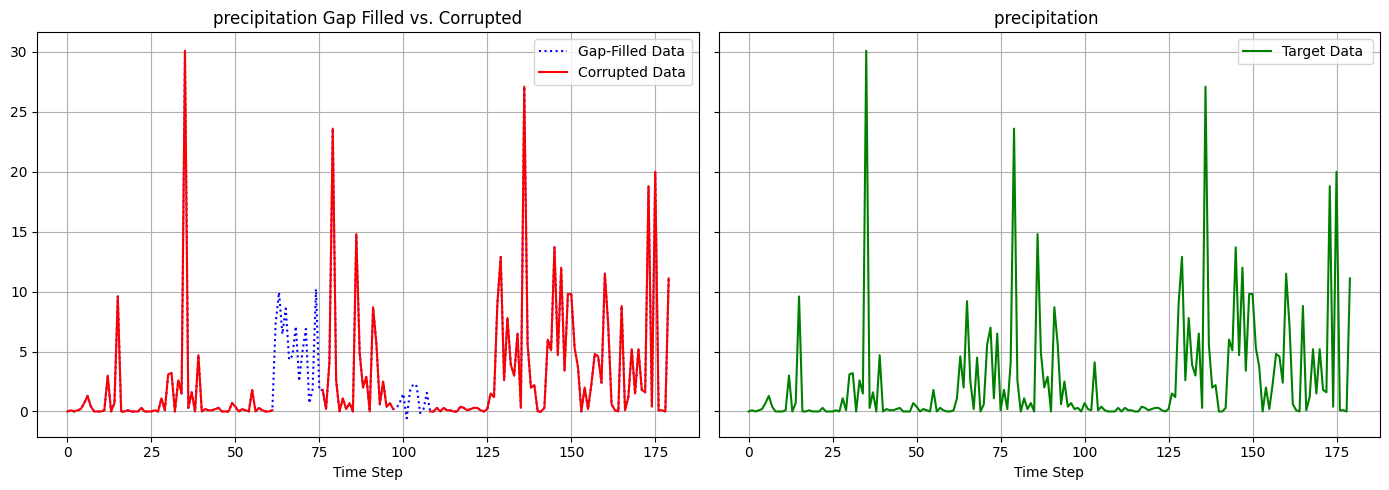

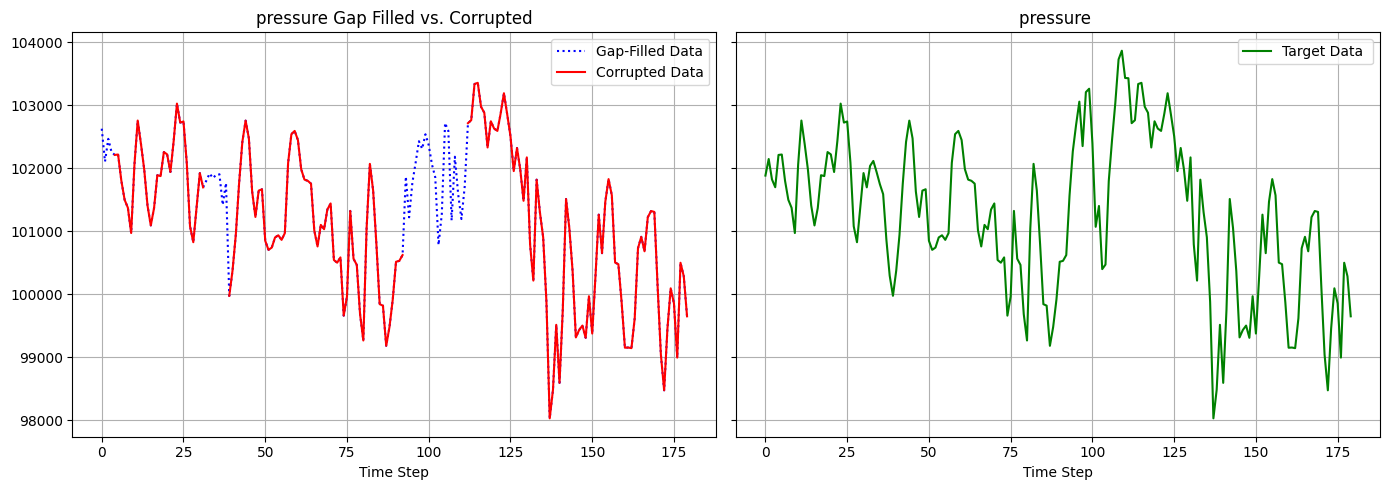

In [126]:
def plot_gap_fillings(filled_sequences, val_loader, device=device):

    #loop over first entry in val loader
    for i, (inputs, targets) in enumerate(val_loader):
        if i == 0:

            #extracting from data loader
            inputs = inputs.to(device)
            targets = targets.to(device)
            corrupted_data = inputs.cpu().numpy()
            target_data = targets.cpu().numpy()
            break

    #unscale all sequences
    corrupted_data_unscaled = scaler.inverse_transform(corrupted_data.reshape(-1, corrupted_data.shape[-1]))
    corrupted_data_unscaled = corrupted_data_unscaled.reshape(corrupted_data.shape)
    target_data_unscaled = scaler.inverse_transform(target_data.reshape(-1, target_data.shape[-1]))
    target_data_unscaled = target_data_unscaled.reshape(target_data.shape)
    filled_sequences_unscaled = scaler.inverse_transform(filled_sequences.reshape(-1, filled_sequences.shape[-1]))
    filled_sequences_unscaled = filled_sequences_unscaled.reshape(filled_sequences.shape)


    #plot using column names from origina data

    for feature_idx, col in enumerate(data_pd.columns):

        # locating sequences for each feature
        filled_seq = filled_sequences_unscaled[0, :, feature_idx]
        corrupted_seq = corrupted_data_unscaled[0, :, feature_idx]
        target_seq = target_data_unscaled[0, :, feature_idx]


        reconstructed_seq = np.copy(corrupted_seq)
        gap_mask = np.isnan(corrupted_seq)

        #locations where mask = 1 (data not corrupted) the reconstructed data matches input data/ modelled data is not used
        reconstructed_seq[gap_mask] = filled_seq[gap_mask]

        fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

        axes[0].plot(reconstructed_seq, label="Gap-Filled Data", linestyle=':', color='blue')
        axes[0].plot(corrupted_seq, label="Corrupted Data", color='red')
        axes[0].set_xlabel("Time Step")
        axes[0].set_title(f"{col} Gap Filled vs. Corrupted")
        axes[0].grid(True)
        axes[0].legend()

        axes[1].plot(target_seq, label="Target Data ", linestyle='-', color='green')
        axes[1].set_xlabel("Time Step")
        axes[1].set_title(f"{col} ")
        axes[1].grid(True)
        axes[1].legend()

        plt.tight_layout()
        plt.show()

plot_gap_fillings(filled_sequences, val_loader, device=device)



### Predicting on Test Set

(3472, 180, 8)


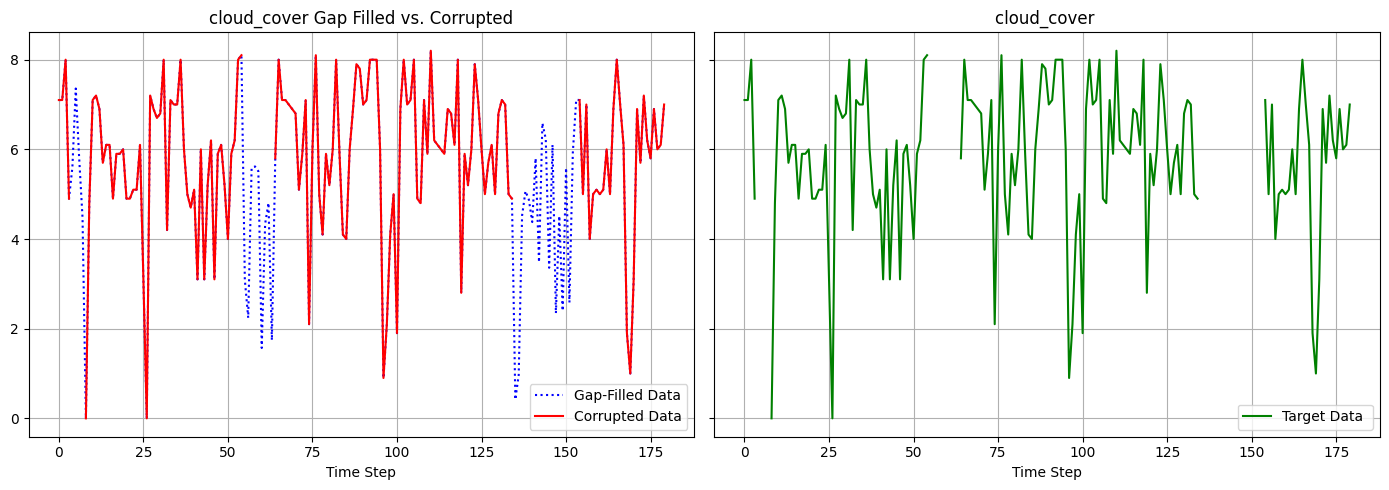

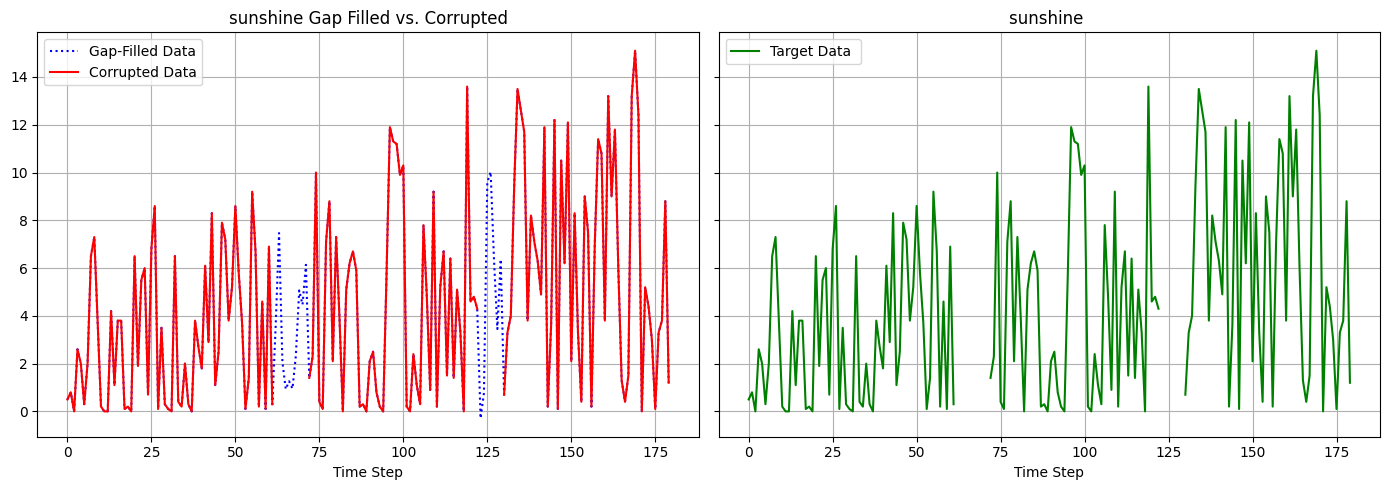

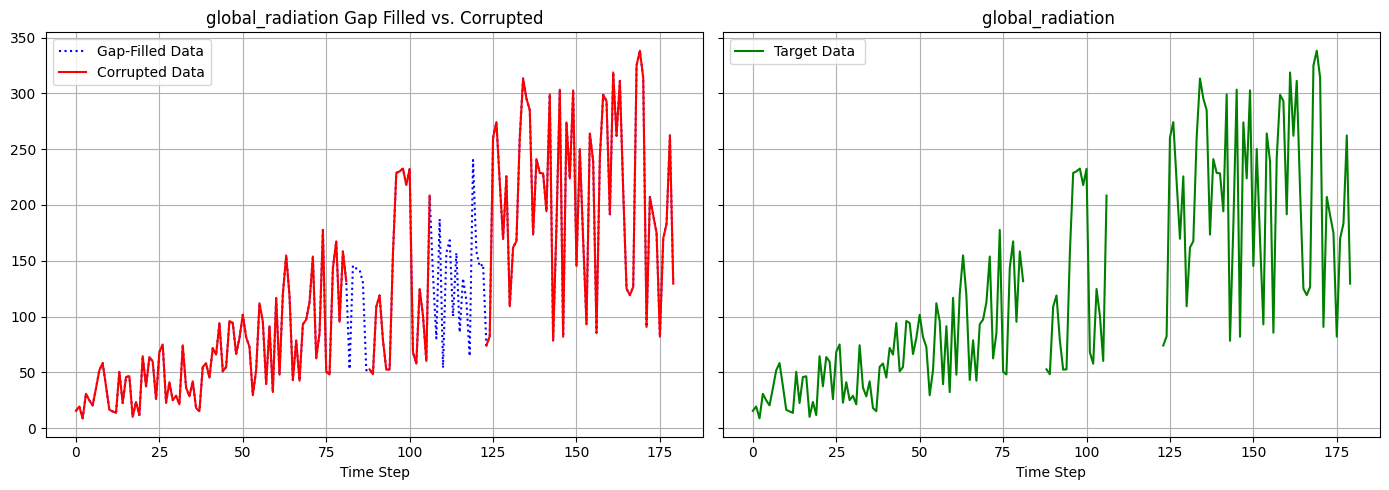

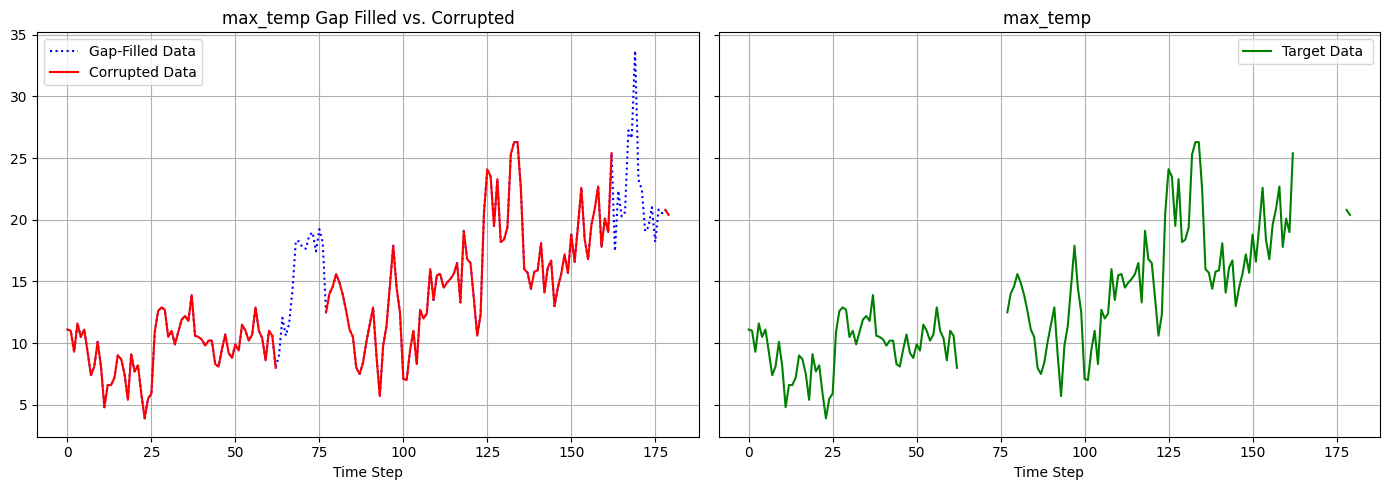

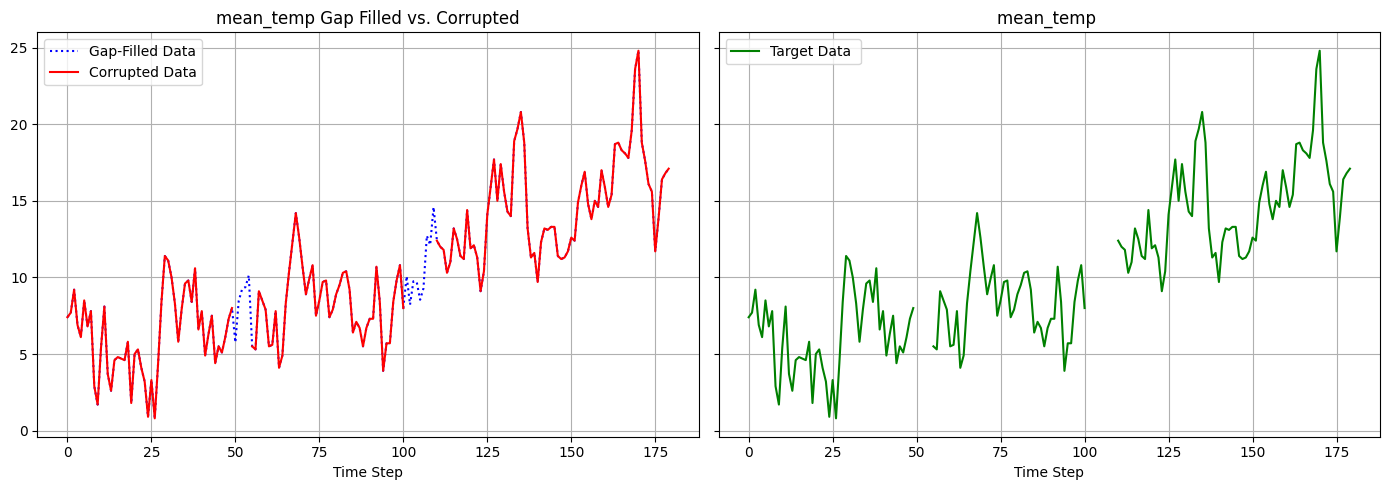

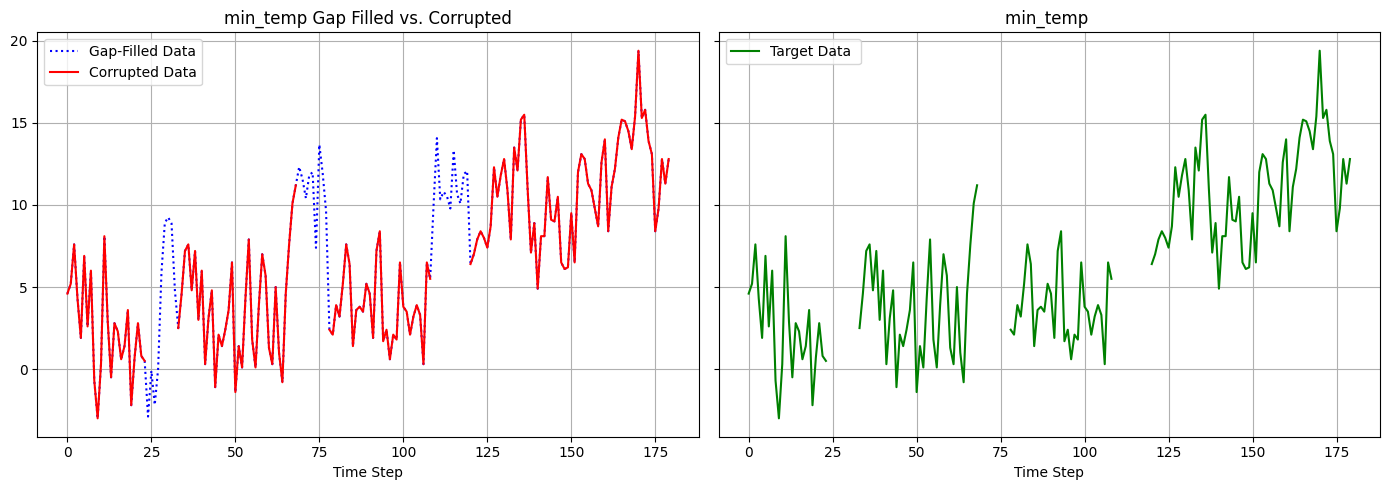

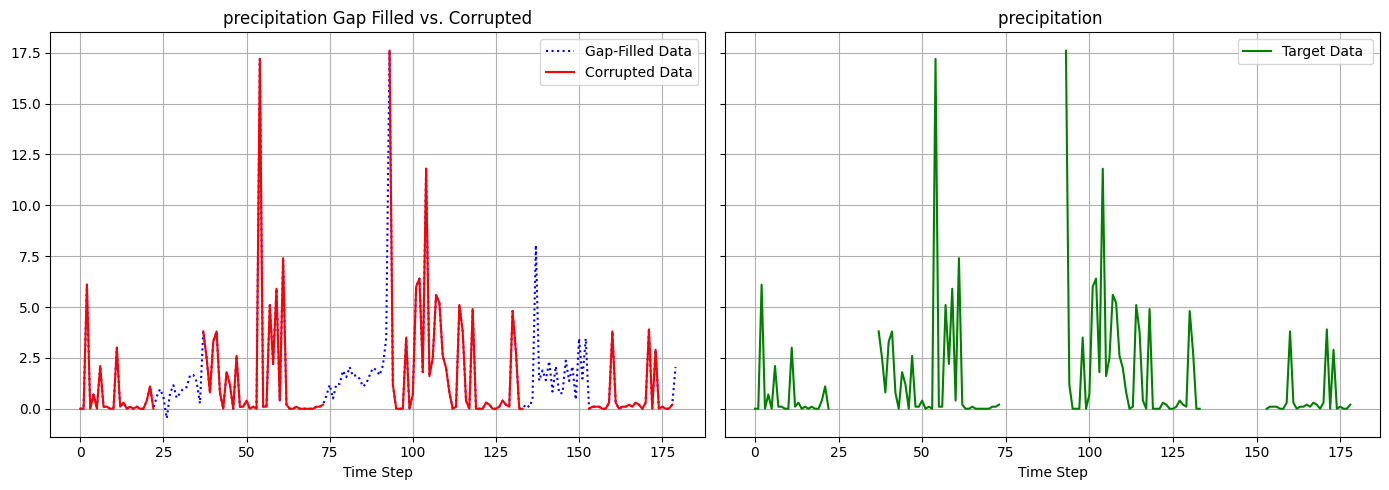

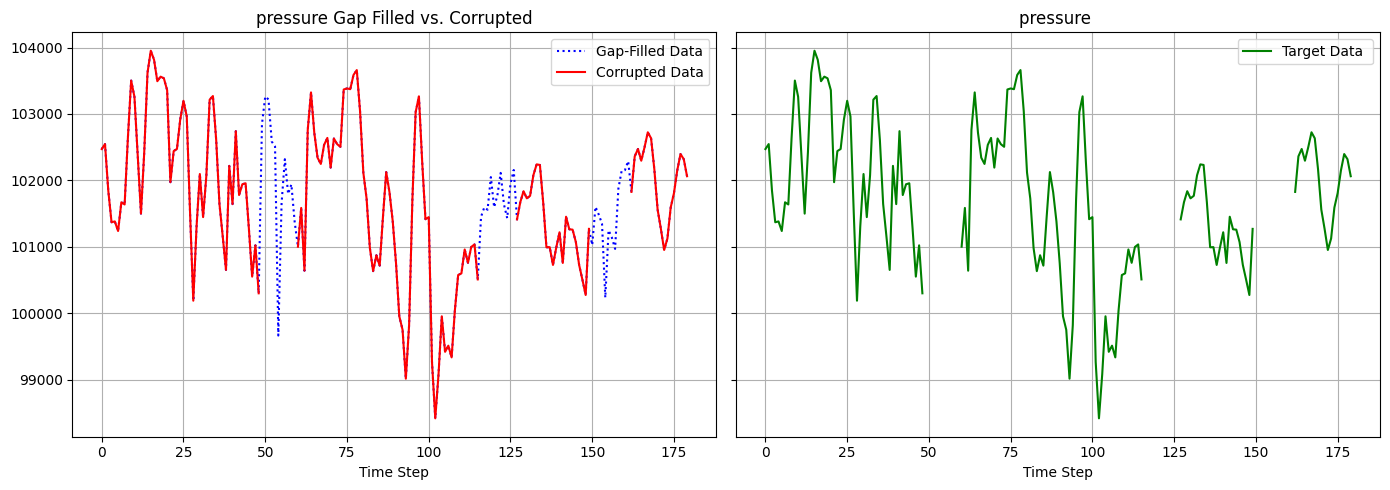

In [127]:
model.eval()
model.to(device)

#initialize predictions
filled_sequences = []

with torch.no_grad():
    for input_seq, _ in test_loader:
        input_seq = input_seq.to(device)
        mask = ~torch.isnan(input_seq)

        #actual predicting using fill_gaos function
        filled_seq = fill_gaps(model, input_seq, mask, device=device)
        filled_seq = filled_seq.cpu().numpy()
        filled_sequences.append(filled_seq)

#output of all filled sequences - note there are repeated values due to sliding window
filled_sequences = np.concatenate(filled_sequences, axis=0)

print(filled_sequences.shape)
plot_gap_fillings(filled_sequences, test_loader, device=device)


<br>

---

<br>

- Overall trends are well followed. The model doesnt produce outliers or unphysical data and the data produced looks as if it could be real, with the exception of rainfall.

- On percipitation in particular there is some unphysical behaviour.There are negative values (which are impossible for percipitaion) and large regions under the graph which indicate prolonged periods of rain lasting days (very unlikely based on the noncorrupted datasets). The unique peak-like structure of the percipitaion data means it is quite hard to model. The rainfall peaks show little structure and do not seem to display any seasonal patterns, unlike other features.


In [ ]:
#get rid of sequences
filled_sequences = filled_sequences[:,-1,:]

#make a df with col headers

test_set_nogaps = pd.DataFrame(filled_sequences, columns=data_pd.columns)

save_path = '/content/drive/My Drive/Data/training_set/'

# Save to the specified location
os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Ensure directory exists
test_set_nogaps.to_csv(save_path, index=False)
print(f"Filled sequences saved to: {save_path}")
